![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from datetime import datetime, timedelta
from collections import Counter
import re

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/additional-city-info/additional_dataset.xlsx


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

Restaurant_id       City                                      Cuisine Style  \
0       id_5569      Paris            ['European', 'French', 'International']   
1       id_1535  Stockholm                                                NaN   
2        id_352     London  ['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...   
3       id_3456     Berlin                                                NaN   
4        id_615     Munich  ['German', 'Central European', 'Vegetarian Fri...   

   Ranking  Rating Price Range  Number of Reviews  \
0   5570.0     3.5    $$ - $$$              194.0   
1   1537.0     4.0         NaN               10.0   
2    353.0     4.5        $$$$              688.0   
3   3458.0     5.0         NaN                3.0   
4    621.0     4.0    $$ - $$$               84.0   

                                             Reviews  \
0  [['Good food at your doorstep', 'A good hotel ...   
1  [['Unique cuisine', 'Delicious Nepalese food']...   
2  [['Catch up with friends', 'Not exceptional'],...   
3                                           [[], []]   
4  [['Best place to try a Bavarian food', 'Nice b...   

                                              URL_TA     ID_TA  
0  /Restaurant_Review-g187147-d1912643-Reviews-R_...  d1912643  
1  /Restaurant_Review-g189852-d7992032-Reviews-Bu...  d7992032  
2  /Restaurant_Review-g186338-d8632781-Reviews-RO...  d8632781  
3  /Restaurant_Review-g187323-d1358776-Reviews-Es...  d1358776  
4  /Restaurant_Review-g187309-d6864963-Reviews-Au...  d6864963

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

Restaurant_id        City  \
0          id_0       Paris   
1          id_1    Helsinki   
2          id_2   Edinburgh   
3          id_3      London   
4          id_4  Bratislava   

                                       Cuisine Style  Ranking Price Range  \
0                                     ['Bar', 'Pub']  12963.0    $$ - $$$   
1  ['European', 'Scandinavian', 'Gluten Free Opti...    106.0    $$ - $$$   
2                            ['Vegetarian Friendly']    810.0    $$ - $$$   
3  ['Italian', 'Mediterranean', 'European', 'Vege...   1669.0        $$$$   
4  ['Italian', 'Mediterranean', 'European', 'Seaf...     37.0        $$$$   

   Number of Reviews                                            Reviews  \
0                4.0                                           [[], []]   
1               97.0  [['Very good reviews!', 'Fine dining in Hakani...   
2               28.0  [['Better than the Links', 'Ivy Black'], ['12/...   
3              202.0  [['Most exquisite', 'Delicious and authentic']...   
4              162.0  [['Always the best in bratislava', 'Very good ...   

                                              URL_TA      ID_TA  
0  /Restaurant_Review-g187147-d10746918-Reviews-L...  d10746918  
1  /Restaurant_Review-g189934-d6674944-Reviews-Ra...   d6674944  
2  /Restaurant_Review-g186525-d13129638-Reviews-B...  d13129638  
3  /Restaurant_Review-g186338-d680417-Reviews-Qui...    d680417  
4  /Restaurant_Review-g274924-d1112354-Reviews-Ma...   d1112354

In [9]:
sample_submission.tail(5)

Restaurant_id  Rating
9995       id_9995     3.0
9996       id_9996     1.5
9997       id_9997     4.5
9998       id_9998     1.0
9999       id_9999     2.5

In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

пункт выше делаем для корректного кодирования признаков,   
так как в одном наборе данных могут встречаться значения отличные от от другого набора,   
соответственно объединяя и обрабатывая данные в одном фрейме мы исключаем такие ошибки.  

добавляя новый столбец "sample" мы знаем потом как небходимо будет разделить на два фрейма после обработки данных.

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
data.sample(5)

Restaurant_id       City  \
13765      id_11314      Paris   
26436        id_698       Lyon   
31642       id_3636  Barcelona   
2653        id_2653     London   
952          id_952   Helsinki   

                                           Cuisine Style  Ranking Price Range  \
13765                  ['Indian', 'Vegetarian Friendly']  11316.0           $   
26436                   ['Italian', 'Pizza', 'European']    699.0    $$ - $$$   
31642             ['Mediterranean', 'Spanish', 'Fusion']   3637.0    $$ - $$$   
2653                                                 NaN   6867.0         NaN   
952    ['Italian', 'Pizza', 'Mediterranean', 'European']    378.0    $$ - $$$   

       Number of Reviews                                            Reviews  \
13765               69.0  [['Nice and Fast Indian Place', 'Rather plain ...   
26436               83.0  [['Excellent pizza', 'Wonderful find on a cool...   
31642               18.0               [['A lot of bread'], ['12/15/2017']]   
2653                 6.0  [['Fab place for fish and chips', 'Exceptional...   
952                107.0  [['just food', 'Cozy Italian restaurant in Hel...   

                                                  URL_TA      ID_TA  sample  \
13765  /Restaurant_Review-g187147-d1126487-Reviews-L_...   d1126487       1   
26436  /Restaurant_Review-g187265-d2371102-Reviews-St...   d2371102       1   
31642  /Restaurant_Review-g187497-d12860859-Reviews-E...  d12860859       1   
2653   /Restaurant_Review-g186338-d12407731-Reviews-H...  d12407731       0   
952    /Restaurant_Review-g189934-d801043-Reviews-Ris...    d801043       0   

       Rating  
13765     3.5  
26436     4.0  
31642     4.0  
2653      0.0  
952       0.0

In [14]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## Ниже напишу свои функции для предобработки данных

In [15]:
def fix_columns(df):
    '''поправляем наименования столбцов'''
    print('fix_columns:','старт функции')
        
    # добавление к функции после get_dummies признака 'cuisine_style'
    # нашелся символ "&" - уберем его (оставим только текст)
    df.columns=df.columns.str.replace(" & ","_")
    
    # заменим в названиях столбцов пробелы на подчеркивание
    df.columns=df.columns.str.replace(" ","_")
    
    # удалим апострофы
    df.columns=df.columns.str.replace("'","")
    
#     df.columns=[x.lower() for x in df.columns]

    # приведем все названия столбцов к нижнему регистру
    df.columns = map(str.lower,df.columns)
    print('fix_columns:','произведенна коррекция наименований столбцов.')
    
    return df

# ---------------------------------------------------------------------------------


def fix_rows(df):
    '''поправляем текст в данных'''
    data=df.copy()
    print('fix_rows:','старт функции')
    
    # сделаем для всего текста уменьшение регистра до нижнего 
    # для исключения опечаток с регистром
    
    #  #   Column             Non-Null Count  Dtype  
    # ---  ------             --------------  -----  
    #  0   restaurant_id      50000 non-null  object 
    #  1   city               50000 non-null  object 
    #  2   cuisine_style      50000 non-null  object 
    #  3   ranking            50000 non-null  float64
    #  4   price_range        50000 non-null  object 
    #  5   number_of_reviews  46800 non-null  float64
    #  6   reviews            50000 non-null  object 
    #  7   url_ta             50000 non-null  object 
    #  8   id_ta              50000 non-null  object 
    #  9   sample             50000 non-null  int64  
    #  10  rating             50000 non-null  float64  

    # составляем список столбцов для уменьшения регистра
    print('fix_rows:','берем список текстовых столбцов для изменения регистра')
    list_of_text=['restaurant_id','city','cuisine_style','price_range','reviews','url_ta','id_ta']
    
    # пройдемся циклом по списку и изменим регистр
    print('fix_rows:','проходимся циклом по составленному списку и изменяем регист на нижний')
    for column in list_of_text:
        data[column] = map(lambda x: str(x).lower(), data[column])
    
    print('fix_rows:','все текстовые столбцы переведены в нижний регистр')

    return df
# ---------------------------------------------------------------------------------


def missing_data(df):
    '''Посмотрим признаки на пропуски данных'''
    data=df.copy()
    print('missing_data:','старт функции')
    
    # создадим список для заполнения данными
    miss_data=[]

    # пройдемся циклом по всем столбцам и запишем результат в наш список
    print('missing_data:','проходим циклом по всем столбцам и считаем пропуски')
    for col in data.columns:
#         print(col) # для проверки прохода по всем столбцам (смутило отсутствие столбца "reviews")
        pct_missing = round(data[col].isna().mean()*100,2)
        nmb_missing = data[col].isna().sum()
        if pct_missing>0:
            miss_data.append([col,pct_missing,nmb_missing])

    # посмотрим на результат (col_name,pct_missing,nmb_missing - 
    # название столбца, процент и число пропусков соответственно)
    print('missing_data:','добавляем столбец с процентами пропусков')
    results_missing=pd.DataFrame(miss_data,columns=['col_name','pct_missing',
                        'nmb_missing']).sort_values(by='pct_missing',ascending=False)
    
#     print('\nВыведем все признаки с пропущенными данными')
#     display(results_missing.head(15))
#     print('\nСтолбцов с пропусками данных:',len(results_missing))  
#     print('Всего не заполнено ячеек:',results_missing.nmb_missing.sum(),' из ', data.size,
#           ' (',round(results_missing.nmb_missing.sum()/data.size*100,2),'%)\n' )
    display(results_missing)
    print('missing_data:','конец функции')    
    #return results_missing

    
# ---------------------------------------------------------------------------------


def list_missing_data(df):
    '''функция на создание списка наименований признаков с пропущенными данными'''
    print('list_missing_data:','старт функции')
    list_missing_data=[]
    
    print('list_missing_data:','проходим циклом по всем столбцам и если есть пропуск - добавляем в список')
    for col in df.columns:
        if df[col].isna().sum()>0:
            list_missing_data.append(col)
    
    print('list_missing_data:','конец функции')
    return list_missing_data

    
# ---------------------------------------------------------------------------------


def info_columns(col=999):
    '''функция по сбору стат информации по столбцу'''
    '''если вызывается просто функция, то показываем инфу по всем столбцам'''
    if col!=999:
        display(data[col].unique())
        display(data[col].nunique())
        display(pd.DataFrame(data[col].value_counts()))
        display(data.loc[:, [col]].describe())
    else:
        fv=[]
        for cl in data.columns:
            fv.append([data[cl].unique(),data[cl].nunique(),data.loc[:, [cl]].describe()])
        display(fv)

    
# ---------------------------------------------------------------------------------


def save_col_wh_nans(df,list_missing_data):
    '''функция по созданию новых признаков _isNAN (по входящему списку и самим данным)'''
    print('save_col_wh_nans:','старт функции')
    data=df.copy()
    
    print('save_col_wh_nans:','проходимся циклом по списку, создаем новый признак по названию столбца +_isNAN и ставим 1 - если есть пропуск, 0 - нету.')
    # пройдемся циклом по столбцам
    save_col_wh_nans
    for col in list_missing_data:
        data[col + '_isNAN'] = data[col].apply(
                        lambda x: int(1) if x=='nan' or pd.isna(x)==int(1) else int(0))
    
    print('save_col_wh_nans:','конец функции')
    return data
    
# ---------------------------------------------------------------------------------


def check_res_of_filling(df,data_org,list_missing_data):
    '''функция по проверке заполнения пропусков'''
    data=df.copy()
    print('check_res_of_filling:','старт функции')
    
    print('check_res_of_filling:','проходим циклом по списку и считаем пропуски в оригинале и нашем рабочем наборе данных')
    for field_name in list_missing_data:
        print('\n',field_name)
#         miss_field_name=field_name+'_isNAN' # собираем имя нового столбца признака пропуска данных
        nmb_missing_was = data_org[field_name].isna().sum()
        nmb_missing_now = data[field_name].isna().sum()
        print('Было пропущенных значений:',nmb_missing_was)
        print('Осталось пропущенных значений:',nmb_missing_now)
        prc_missing_now = round(data[field_name].isnull().mean()*100, 2)
        print(f'Текущий процент пропущенных значений: {prc_missing_now}%')
    
    print('check_res_of_filling:','конец функции')
    
    
# ---------------------------------------------------------------------------------

def clear_string(txt):
    '''отчистка текста от ненужных символов'''
    # учитывая, что данная функция работает построчно - то появление здесь функции print привело бы к захламлению лога-процесса работы других функций
    # поэтому лучше я поставлю в других функциях вывод информации, что запускается данная функция.
    
    txt=str(txt).strip()

    for simb in ['[', ']', "'", '"', ' & ']:
        if simb in txt:
            if simb==' & ':
                txt = txt.replace(simb, ' ')
            else:
                txt = txt.replace(simb, '')
    return txt

# ---------------------------------------------------------------------------------


# ---------------------------------------------------------------------------------


# функция определения значений выбросов
def blowouts(field,df):
    
    IQR = df.loc[:, field].quantile(0.75) - df.loc[:, field].quantile(0.25)
    perc25 = df.loc[:, field].quantile(0.25)
    perc50 = df.loc[:, field].quantile(0.50)
    perc75 = df.loc[:, field].quantile(0.75)
    low_border=perc25 - 1.5*IQR
    high_border=perc75 + 1.5*IQR
    
    # посчитаем количество выбросов ниже нижней границы
    num_down_blowouts=len(df[df[field]<=low_border])
    
    # выведем соответствующее сообщение (от результатов подсчета нижних выбросов)
    if num_down_blowouts>0:
        mes_d='Нижние выбросы есть, их: ' + str(num_down_blowouts) + '.'
    else:
        mes_d='Нижних выбросов нет.'
    
    # посчитаем количество выбросов выше верхней границы
    num_up_blowouts=len(df[df.loc[:, field]>=high_border])
    
    # выведем соответствующее сообщение (от результатов подсчета верхних выбросов)
    if num_up_blowouts>0:
        mes_u='Верхние выбросы есть, их: ' + str(num_up_blowouts) + '.'
    else:
        mes_u='Верхних выбросов нет.'
    
#     print('----------------------------------------------------------------------------------------------------------------')
    count=df[field].describe().transpose()[0]
    mean=df[field].describe().transpose()[1]
    std=df[field].describe().transpose()[2]
    minim=df[field].describe().transpose()[3]
    maxim=df[field].describe().transpose()[7]

#     print(
#     '25-й перцентиль: {},'.format(perc25),
#     '75-й перцентиль: {},'.format(perc75),
#     "IQR: {}, ".format(IQR),
#     "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    
#     print('----------------------------------------------------------------------------------------------------------------')
#     print(mes_d,mes_u)
#     print('----------------------------------------------------------------------------------------------------------------')
    

    data=[field,count,mean,std,IQR,perc25,perc50,perc75,
          low_border,high_border,num_down_blowouts,num_up_blowouts,minim,maxim]
#     res=pd.DataFrame(data ,columns=['column','count','mean','std','IQR','perc25','perc50','perc75',
#                                  'low_border','high_border','num_down_blowouts',
#                                  'num_up_blowouts','minim','maxim'])
    
    # вернем результат вычислений функции
    return data

# ---------------------------------------------------------------------------------

# функция построения boxplot-а
def get_boxplot(column,df):
    fig, ax = plt.subplots(figsize = (10, 5))
    sns.boxplot(data[column],ax=ax)
#     plt.xticks(rotation=45)
#     ax.set_title('Boxplot для ' + column)
    plt.show()
    
# ---------------------------------------------------------------------------------
# сделаю общую функцию для просмотра статистики по признаку (числовому)    
def col_info(column,data):
    get_boxplot(column,data)
    dg=[]
    dg.append(blowouts(column,data))
    print('\n\nПосмотрим на статистику по данному столбцу')
    display(pd.DataFrame(dg,columns=['column_name','count','mean','std','IQR','perc25','perc50','perc75', 'low_border','high_border','num_down_blowouts', 'num_up_blowouts','minim','maxim']))

In [16]:
data=fix_columns(data)
data=save_col_wh_nans(data,list_missing_data(data))

fix_columns: старт функции
fix_columns: произведенна коррекция наименований столбцов.
list_missing_data: старт функции
list_missing_data: проходим циклом по всем столбцам и если есть пропуск - добавляем в список
list_missing_data: конец функции
save_col_wh_nans: старт функции
save_col_wh_nans: проходимся циклом по списку, создаем новый признак по названию столбца +_isNAN и ставим 1 - если есть пропуск, 0 - нету.
save_col_wh_nans: конец функции


Дубликатов найдено: 0


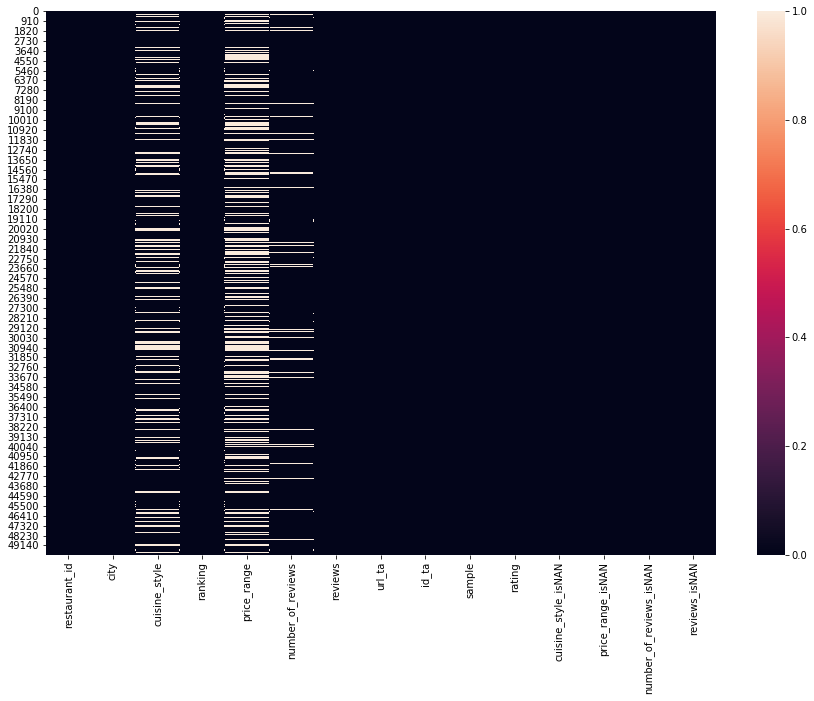

In [17]:
# посмотрим есть ли дубликаты строчек в данных
print("Дубликатов найдено:", data.duplicated(keep=False).sum())

# и посмотрим внимательнее на данные с пропусками
plt.subplots(figsize=(15, 10))
sns.heatmap(data.isnull())

In [18]:
# посмотрим сколько же пропусков у нас есть
missing_data(data)

missing_data: старт функции
missing_data: проходим циклом по всем столбцам и считаем пропуски
missing_data: добавляем столбец с процентами пропусков


col_name  pct_missing  nmb_missing
1        price_range        34.72        17361
0      cuisine_style        23.18        11590
2  number_of_reviews         6.40         3200

missing_data: конец функции


In [19]:
# создадим список числовых признаков в данных
cols_numb = data.select_dtypes(include='number').columns

# посмотрим на статданные по этим столбцам
list_stat=[]
  
for col in cols_numb:
    #  исключаем наши новые служебные столбцы "_isNAN"    
    if col.endswith('_isNAN')==False: 
        list_stat.append(blowouts(col,data))
    
display(pd.DataFrame(list_stat,columns=['column_name','count','mean','std','IQR','perc25','perc50','perc75', 'low_border','high_border','num_down_blowouts', 'num_up_blowouts','minim','maxim']))

column_name    count         mean          std     IQR  perc25  \
0            ranking  50000.0  3664.427520  3700.092452  4269.0   972.0   
1  number_of_reviews  46800.0   124.471197   294.114345   106.0     9.0   
2             sample  50000.0     0.800000     0.400004     0.0     1.0   
3             rating  50000.0     3.194430     1.705453     1.5     3.0   

   perc50  perc75  low_border  high_border  num_down_blowouts  \
0  2278.0  5241.0    -5431.50     11644.50                  0   
1    33.0   115.0     -150.00       274.00                  0   
2     1.0     1.0        1.00         1.00              50000   
3     4.0     4.5        0.75         6.75              10000   

   num_up_blowouts  minim    maxim  
0             3075    1.0  16444.0  
1             5459    2.0   9660.0  
2            40000    0.0      1.0  
3                0    0.0      5.0

поскольку столбец sample у нас служебный - на него не смотрим.  

А вот столбцы "Ranking" и "Number of Reviews" похоже имеют выбросы и причем много (3075 и 5459 соответственно).  
И точно надо будет заменить на другие значения

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [20]:
# напишу одну функцию заполняющую все 4 первых признака (для облегчения кода на финальной стадии)

def cut_outliers(col,df,low_predel):
    # заменю выбросы на нижнюю границу выбранного предела
    df[col] = df[col].apply(lambda x: low_predel if x > low_predel else x)
    return df

# ---------------------------------------------------------------------------------

def fill_first_cloumns(df):
    print('fill_first_cloumns:','старт функции')
    data=df
    
    #  заменим выбросы в столбце 'number_of_reviews'
    low_predel=3500
    column='number_of_reviews'
    data=cut_outliers(column,data,low_predel)
    
    #  заменим выбросы в столбце 'ranking'
    low_predel=11644.5
    column='ranking'
    data=cut_outliers(column,data,low_predel)
    
    # нормализуем признак
    column='number_of_reviews'
    print('fill_first_cloumns:','нормализуем признак "number_of_reviews"')
    data[column + '_norm'] = np.log2(data[column])
    
    # поскольку кухнь в данных много - мы не можем сделать однозначный выбор, поэтому ставим "other"
    print('fill_first_cloumns:','заполняем пропуски признака "cuisine_style" значением "Other"')
    data['cuisine_style'] = data['cuisine_style'].fillna('Other')
    
    # аналогично с предыдущем полем, пропусков слишком много - ставим значение "other"
    print('fill_first_cloumns:','заполняем пропуски признака "price_range" значением "Other"')
    data['price_range']=data['price_range'].fillna('Other')
    
    # заполним пропуски средним значением по городу
    print('fill_first_cloumns:','заполняем пропуски признака "number_of_reviews" среднегородским числом отзывов по городу')
    data['number_of_reviews'] = data.groupby("city")['number_of_reviews'].transform(lambda x: x.fillna(round(x.mean())))
#     data.loc[data['number_of_reviews'].isnull(),['number_of_reviews']] = data.groupby(['city'])['number_of_reviews'].transform('mean')
    
    # заполним два пустых значения '[[], []]' - так как у нас таких много и это по-сути тоже пропуски в данных
    print('fill_first_cloumns:','заполняем пропуски признака "reviews" значением "[[], []]"')
    data['reviews'] = data['reviews'].fillna("[[], []]")
    
    
    print('fill_first_cloumns:','конец функции')
    return data

## Посмотрим на столбец "Number of Reviews"

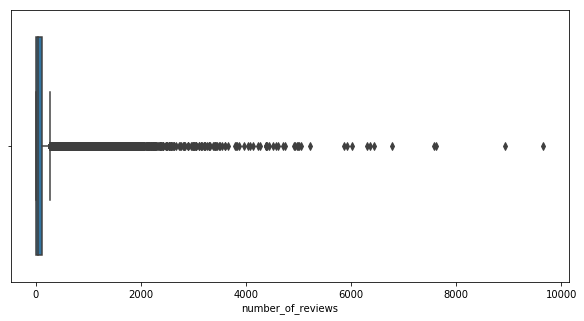



Посмотрим на статистику по данному столбцу


column_name    count        mean         std    IQR  perc25  perc50  \
0  number_of_reviews  46800.0  124.471197  294.114345  106.0     9.0    33.0   

   perc75  low_border  high_border  num_down_blowouts  num_up_blowouts  minim  \
0   115.0      -150.0        274.0                  0             5459    2.0   

    maxim  
0  9660.0

In [21]:
column='number_of_reviews'
col_info(column,data)

Попробую пока не сразу все выбросы заменить, тк может это может быть правдой выбросов слишком много.
попробую поиграть с границей - начну с 3500.

In [22]:
# заменю выбросы на нижнюю границу выбранного предела
# сделал функцию cut_outliers(column,data,low_predel)

# low_predel=3500

# data[column] = data[column].apply(lambda x: low_predel if x > low_predel else x)

In [23]:
column='number_of_reviews'
print('заполняем пропуски признака "number_of_reviews" среднегородским числом отзывов по городу')
data[column] = data.groupby("city")[column].transform(lambda x: x.fillna(round(x.mean())))

заполняем пропуски признака "number_of_reviews" среднегородским числом отзывов по городу


In [24]:
# нормализуем признак
data[column + '_norm'] = np.log2(data[column])

In [25]:
# заменю выбросы на нижнюю границу выбранного предела
# low_predel=3500
# data=cut_outliers(column,data,low_predel)

## Посмотрим на столбец "ranking"

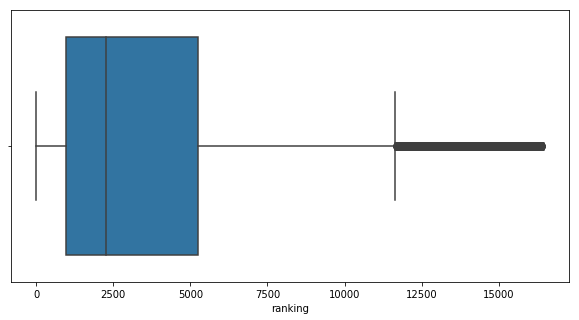



Посмотрим на статистику по данному столбцу


column_name    count        mean          std     IQR  perc25  perc50  \
0     ranking  50000.0  3664.42752  3700.092452  4269.0   972.0  2278.0   

   perc75  low_border  high_border  num_down_blowouts  num_up_blowouts  minim  \
0  5241.0     -5431.5      11644.5                  0             3075    1.0   

     maxim  
0  16444.0

In [26]:
column='ranking'
col_info(column,data)

о как интересно, тут явные выбросы свыше **high_border**, заменим всё что выше этой границы на саму границу

In [27]:
# заменю выбросы на нижнюю границу выбранного предела
# low_predel=11644.5
# data=cut_outliers(column,data,low_predel)

## перейду к заполнению пропусков в данных

In [28]:
    column='cuisine_style'
    # поскольку кухнь в данных много - мы не можем сделать однозначный выбор, поэтому ставим "other"
    print('заполняем пропуски признака "cuisine_style" значением "Other"')
    data[column] = data[column].fillna('Other')

заполняем пропуски признака "cuisine_style" значением "Other"


In [29]:
    column='price_range'
    # аналогично с предыдущем полем, пропусков слишком много - заполняем пропуски среднегородским значением
    print('заполняем пропуски признака "price_range" значением "Other"')
    data[column]=data[column].fillna('Other')

заполняем пропуски признака "price_range" значением "Other"


In [30]:
# у столбца rating нет выбросов, поэтому применим все наши наработки на нашем наборе данных
data=fill_first_cloumns(data)

fill_first_cloumns: старт функции
fill_first_cloumns: нормализуем признак "number_of_reviews"
fill_first_cloumns: заполняем пропуски признака "cuisine_style" значением "Other"
fill_first_cloumns: заполняем пропуски признака "price_range" значением "Other"
fill_first_cloumns: заполняем пропуски признака "number_of_reviews" среднегородским числом отзывов по городу
fill_first_cloumns: заполняем пропуски признака "reviews" значением "[[], []]"
fill_first_cloumns: конец функции


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
restaurant_id              50000 non-null object
city                       50000 non-null object
cuisine_style              50000 non-null object
ranking                    50000 non-null float64
price_range                50000 non-null object
number_of_reviews          50000 non-null float64
reviews                    50000 non-null object
url_ta                     50000 non-null object
id_ta                      50000 non-null object
sample                     50000 non-null int64
rating                     50000 non-null float64
cuisine_style_isNAN        50000 non-null int64
price_range_isNAN          50000 non-null int64
number_of_reviews_isNAN    50000 non-null int64
reviews_isNAN              50000 non-null int64
number_of_reviews_norm     50000 non-null float64
dtypes: float64(4), int64(5), object(7)
memory usage: 6.1+ MB


## отлично с пропусками справились

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [32]:
data.nunique(dropna=False)

restaurant_id              13094
city                          31
cuisine_style              10732
ranking                    10338
price_range                    4
number_of_reviews           1532
reviews                    41857
url_ta                     49963
id_ta                      49963
sample                         2
rating                        10
cuisine_style_isNAN            2
price_range_isNAN              2
number_of_reviews_isNAN        2
reviews_isNAN                  2
number_of_reviews_norm      1532
dtype: int64

Какие признаки можно считать категориальными?  

алгоритмы машинного обучения не могут работать напрямую с категориальными данными,  
и вам необходимо выполнить некоторое количество разработки и преобразования этих данных, прежде чем вы сможете начать моделирование ваших данных.  


Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:  

![](https://i.imgur.com/mtimFxh.png)

In [33]:
def processing_cities(df):
    print('processing_cities:','старт функции')
    dg=pd.get_dummies(df['city'],prefix='city',dummy_na=False)
    df=pd.concat([df,dg],axis=1)
    print('processing_cities:','разбивка и коррекция столбца "city" закончена')
    return df

In [34]:
dg=data.copy()
dt=pd.get_dummies(dg['city'],prefix='city',dummy_na=False)
dt=pd.concat([dg,dt],axis=1)
dt.head()

restaurant_id        city  \
0          id_0       Paris   
1          id_1    Helsinki   
2          id_2   Edinburgh   
3          id_3      London   
4          id_4  Bratislava   

                                       cuisine_style  ranking price_range  \
0                                     ['Bar', 'Pub']  11644.5    $$ - $$$   
1  ['European', 'Scandinavian', 'Gluten Free Opti...    106.0    $$ - $$$   
2                            ['Vegetarian Friendly']    810.0    $$ - $$$   
3  ['Italian', 'Mediterranean', 'European', 'Vege...   1669.0        $$$$   
4  ['Italian', 'Mediterranean', 'European', 'Seaf...     37.0        $$$$   

   number_of_reviews                                            reviews  \
0                4.0                                           [[], []]   
1               97.0  [['Very good reviews!', 'Fine dining in Hakani...   
2               28.0  [['Better than the Links', 'Ivy Black'], ['12/...   
3              202.0  [['Most exquisite', 'Delicious and authentic']...   
4              162.0  [['Always the best in bratislava', 'Very good ...   

                                              url_ta      id_ta  sample  \
0  /Restaurant_Review-g187147-d10746918-Reviews-L...  d10746918       0   
1  /Restaurant_Review-g189934-d6674944-Reviews-Ra...   d6674944       0   
2  /Restaurant_Review-g186525-d13129638-Reviews-B...  d13129638       0   
3  /Restaurant_Review-g186338-d680417-Reviews-Qui...    d680417       0   
4  /Restaurant_Review-g274924-d1112354-Reviews-Ma...   d1112354       0   

   rating  cuisine_style_isNAN  price_range_isNAN  number_of_reviews_isNAN  \
0     0.0                    0                  0                        0   
1     0.0                    0                  0                        0   
2     0.0                    0                  0                        0   
3     0.0                    0                  0                        0   
4     0.0                    0                  0                        0   

   reviews_isNAN  number_of_reviews_norm  city_Amsterdam  city_Athens  \
0              0                2.000000               0            0   
1              0                6.599913               0            0   
2              0                4.807355               0            0   
3              0                7.658211               0            0   
4              0                7.339850               0            0   

   city_Barcelona  city_Berlin  city_Bratislava  city_Brussels  city_Budapest  \
0               0            0                0              0              0   
1               0            0                0              0              0   
2               0            0                0              0              0   
3               0            0                0              0              0   
4               0            0                1              0              0   

   city_Copenhagen  city_Dublin  city_Edinburgh  city_Geneva  city_Hamburg  \
0                0            0               0            0             0   
1                0            0               0            0             0   
2                0            0               1            0             0   
3                0            0               0            0             0   
4                0            0               0            0             0   

   city_Helsinki  city_Krakow  city_Lisbon  city_Ljubljana  city_London  \
0              0            0            0               0            0   
1              1            0            0               0            0   
2              0            0            0               0            0   
3              0            0            0               0            1   
4              0            0            0               0            0   

   city_Luxembourg  city_Lyon  city_Madrid  city_Milan  city_Munich  \
0                0          0            0           0          

dummy_na=True добавляет дополнительный столбец City_nan и если город пропущен то в этом столбце будет проставлена 1

In [35]:
data.head(5)

restaurant_id        city  \
0          id_0       Paris   
1          id_1    Helsinki   
2          id_2   Edinburgh   
3          id_3      London   
4          id_4  Bratislava   

                                       cuisine_style  ranking price_range  \
0                                     ['Bar', 'Pub']  11644.5    $$ - $$$   
1  ['European', 'Scandinavian', 'Gluten Free Opti...    106.0    $$ - $$$   
2                            ['Vegetarian Friendly']    810.0    $$ - $$$   
3  ['Italian', 'Mediterranean', 'European', 'Vege...   1669.0        $$$$   
4  ['Italian', 'Mediterranean', 'European', 'Seaf...     37.0        $$$$   

   number_of_reviews                                            reviews  \
0                4.0                                           [[], []]   
1               97.0  [['Very good reviews!', 'Fine dining in Hakani...   
2               28.0  [['Better than the Links', 'Ivy Black'], ['12/...   
3              202.0  [['Most exquisite', 'Delicious and authentic']...   
4              162.0  [['Always the best in bratislava', 'Very good ...   

                                              url_ta      id_ta  sample  \
0  /Restaurant_Review-g187147-d10746918-Reviews-L...  d10746918       0   
1  /Restaurant_Review-g189934-d6674944-Reviews-Ra...   d6674944       0   
2  /Restaurant_Review-g186525-d13129638-Reviews-B...  d13129638       0   
3  /Restaurant_Review-g186338-d680417-Reviews-Qui...    d680417       0   
4  /Restaurant_Review-g274924-d1112354-Reviews-Ma...   d1112354       0   

   rating  cuisine_style_isNAN  price_range_isNAN  number_of_reviews_isNAN  \
0     0.0                    0                  0                        0   
1     0.0                    0                  0                        0   
2     0.0                    0                  0                        0   
3     0.0                    0                  0                        0   
4     0.0                    0                  0                        0   

   reviews_isNAN  number_of_reviews_norm  
0              0                2.000000  
1              0                6.599913  
2              0                4.807355  
3              0                7.658211  
4              0                7.339850

In [36]:
data.sample(5)

restaurant_id       city                        cuisine_style  ranking  \
31738        id_622   Budapest      ['Cafe', 'Turkish', 'European']    623.0   
13393       id_6492  Barcelona                  ['Asian', 'Korean']   6493.0   
18204       id_4324      Milan  ['Italian', 'Bar', 'Mediterranean']   4327.0   
7977        id_7977  Edinburgh                                Other   1334.0   
19304       id_4054     Prague                ['European', 'Czech']   4068.0   

      price_range  number_of_reviews  \
31738    $$ - $$$              143.0   
13393       Other                4.0   
18204    $$ - $$$              337.0   
7977        Other                3.0   
19304       Other              124.0   

                                                 reviews  \
31738  [['Kara cafè', 'Relaxing patio'], ['09/04/2017...   
13393                                           [[], []]   
18204  [['Great drinks and nibbles- service could be....   
7977   [['Locally sourced, freshly cooked to order.',...   
19304                                           [[], []]   

                                                  url_ta      id_ta  sample  \
31738  /Restaurant_Review-g274887-d946623-Reviews-Kar...    d946623       1   
13393  /Restaurant_Review-g187497-d4060319-Reviews-Vi...   d4060319       1   
18204  /Restaurant_Review-g187849-d951743-Reviews-Fra...    d951743       1   
7977   /Restaurant_Review-g186525-d6091204-Reviews-Du...   d6091204       0   
19304  /Restaurant_Review-g274707-d11535573-Reviews-M...  d11535573       1   

       rating  cuisine_style_isNAN  price_range_isNAN  \
31738     4.0                    0                  0   
13393     3.5                    0                  1   
18204     3.0                    0                  0   
7977      0.0                    1                  1   
19304     2.0                    0                  1   

       number_of_reviews_isNAN  reviews_isNAN  number_of_reviews_norm  
31738                        0              0                7.159871  
13393                        0              0                2.000000  
18204                        0              0                8.396605  
7977                         0              0                1.584963  
19304                        1              0                6.954196

#### Возьмем следующий признак "Price Range".

In [37]:
# наименование столбца заменено на моё
data['price_range'].value_counts()

$$ - $$$    23041
Other       17361
$            7816
$$$$         1782
Name: price_range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [38]:
# Ваша обработка 'Price Range'
def processing_price_range_v1(df):
    '''вариант 1 - замена на цифры '''
    print('processing_price_range_v1:','старт функции')
    data=df.copy()
    
    print('processing_price_range_v1:','получаем новый признак "price_range_in_num" (заменяем с помощью функции replace по словарю)')
    dict_price_range = {'$': 1, '$$ - $$$': 2, '$$$$': 3, 'Other' : np.nan}
    data['price_range_in_num'] = data['price_range'].replace(to_replace=dict_price_range)
    
    # новое. появилась мысль заменить пропуски не нулями, а среднегородскими значениями
    data['price_range_in_num'] = data.groupby("city")['price_range_in_num'].transform(lambda x: x.fillna(round(x.mean()))).astype(int)
    
    print('processing_price_range_v1:','конец функции')
    return data
    
# ---------------------------------------------------------------------------------------

def processing_price_range_v2(df):
    '''вариант 2 - замена на get_dummies '''
    print('processing_price_range_v2:','старт функции')    
    
    print('processing_price_range_v2:','получаем новые признаки с префиксом "price_range" (используем функцию get_dummies)')
    df=df.join(pd.get_dummies(df['price_range_in_num'],prefix='price_range'))
    
    print('processing_price_range_v2:','конец функции')
    return df

# ---------------------------------------------------------------------------------------

In [39]:
# применим к нашему набору данных все изменения
data=processing_price_range_v1(data)
data=processing_price_range_v2(data)

processing_price_range_v1: старт функции
processing_price_range_v1: получаем новый признак "price_range_in_num" (заменяем с помощью функции replace по словарю)
processing_price_range_v1: конец функции
processing_price_range_v2: старт функции
processing_price_range_v2: получаем новые признаки с префиксом "price_range" (используем функцию get_dummies)
processing_price_range_v2: конец функции


> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [40]:
# тут ваш код на обработку других признаков
# .....

## Возьмем следующий признак "cuisine_style".

In [41]:
df=data.copy()
# display(type(data['Cuisine Style']))
df['cuisine_style'] = df['cuisine_style'].apply(lambda x: np.nan if pd.isna(x) else str(x).strip('[]').replace("'","").split(", "))

cuisine_style_freq=pd.DataFrame(df['cuisine_style'].explode().value_counts(ascending=False))#.rename(columns=['freq'])
cuisine_style_freq.rename(columns={'cuisine_style':'freq'},inplace = True)
# print(cuisine_style_freq.head())
cuisine_style_freq['top_accum_prc']=round(cuisine_style_freq['freq'].cumsum()/cuisine_style_freq['freq'].sum()*100,2)

print(list(cuisine_style_freq.index))

['Vegetarian Friendly', 'European', 'Other', 'Mediterranean', 'Italian', 'Vegan Options', 'Gluten Free Options', 'Bar', 'French', 'Asian', 'Pizza', 'Spanish', 'Pub', 'Cafe', 'Fast Food', 'British', 'International', 'Seafood', 'Japanese', 'Central European', 'American', 'Sushi', 'Chinese', 'Portuguese', 'Indian', 'Middle Eastern', 'Thai', 'Wine Bar', 'German', 'Halal', 'Greek', 'Healthy', 'Fusion', 'Czech', 'Steakhouse', 'Barbecue', 'Contemporary', 'Soups', 'Eastern European', 'Vietnamese', 'Grill', 'Gastropub', 'Turkish', 'Mexican', 'South American', 'Delicatessen', 'Austrian', 'Polish', 'Scandinavian', 'Hungarian', 'Lebanese', 'Diner', 'Latin', 'Dutch', 'Irish', 'Street Food', 'Belgian', 'Brew Pub', 'Danish', 'Swiss', 'Swedish', 'Argentinean', 'Korean', 'Scottish', 'African', 'Moroccan', 'Central American', 'Brazilian', 'Pakistani', 'Peruvian', 'Caribbean', 'Nepali', 'Balti', 'Bangladeshi', 'Norwegian', 'Israeli', 'Slovenian', 'Persian', 'Indonesian', 'Russian', 'Arabic', 'Kosher', 'V

In [42]:
# ---------------------------------------------------------------------------------------

# функция создания списка кухонь

def get_list_of_cuisines(df):
    print('get_list_of_cuisines:','старт функции')
    cuisine_style_freq=pd.DataFrame(df['cuisine_style'].explode().value_counts(ascending=False))
    cuisine_style_freq.rename(columns={'cuisine_style':'freq'},inplace = True)
    
    # поработаем еще с списком кухонь - добавим накопительный процент по наиболее частой встрече в ресторанах
    print('get_list_of_cuisines:','добавляем столбец накопительный процент вхождений')
    cuisine_style_freq['top_accum_prc']=round(cuisine_style_freq['freq'].cumsum()/cuisine_style_freq['freq'].sum()*100,2)

    print('get_list_of_cuisines:','конец функции') 
    return cuisine_style_freq

  
# ---------------------------------------------------------------------------------------

# получается, что ТОП-10 встречающихся кухонь встречаются в более чем 60% ресторанов.
# возьмем первые 5 (без учета "Other")  и создадим новый признак наличия в ресторане кухни из топ-5
# дополнительно. уменьшил до 3-х и сделал новую функцию - есть ли в ресторане хотя бы одна кухня из ТОП-3 (1-Да, 0-Нет)

def cuis_in_top(x,top_cuisines):
    # функция служебная о запуске ёё буду сообщать в другой функции (из которой запускаю)
    n=0
    for top in top_cuisines:
        if top in x:
            n=1
    return n    

# -----------------------------------

def top_cuis(cuisine_style_freq):
    print('top_cuis:','старт функции') 
    top_cuisines=[]
    top_numb=3
    top_count=0
    
    print('top_cuis:','проходим циклом по списку, берем первые пять кухонь (за исключением Other)') 
    for item in cuisine_style_freq.index:
        if top_count==top_numb:
            break
        else:
            if item!='Other':
                top_cuisines.append(item)
                top_count+=1
                
    print('top_cuis:','конец функции') 
    return top_cuisines

   
# ---------------------------------------------------------------------------------------


# теперь создадим признак на присутствие в ресторане наиболее редких кухонь
# поступим по другому (в отличие от ТОП-5 наиболее встречающихся)
# отберем наиболее редкие кухни циклом, возьмем кухни дающие последние 0.5% в показателе 'cuisine_style_freq.top_accum_prc'
def rare_cuis(cuisine_style_freq):
    print('rare_cuis:','старт функции') 
    rare_cuisines=[]
    tail_prc=99.5
    
    print('rare_cuis:','проходим циклом по списку кухонь, берем все у которых накопительный процент больше или равен 99.5%') 
    for item in range(0,len(cuisine_style_freq)):
        if cuisine_style_freq.top_accum_prc.iloc[item]>=tail_prc:
            rare_cuisines.append(cuisine_style_freq.index[item])
    
    print('rare_cuis:','конец функции')    
    return rare_cuisines

# функции по работе с признаком 'cuisine_style'

#     -----------------------------------------------------------------------------------------------
    
# функция по расчету наиболее встречающихся кухонь
def calc_amount_tops(x,top_cuisines):
    # функция служебная о запуске ёё буду сообщать в другой функции (из которой запускаю)
    n=0
    for top in top_cuisines:
        if top in x:
            n+=1
    return n


#     -----------------------------------------------------------------------------------------------

# теперь напишем функцию по расчету редких кухонь для каждого ресторана
def calc_amount_rare(x,rare_cuisines):
    # функция служебная о запуске ёё буду сообщать в другой функции (из которой запускаю)
    n=0
    if x=='nan':
        return 0
    for tail in rare_cuisines:
        if tail in x:
            n+=1
    return n    


#     -----------------------------------------------------------------------------------------------
    
# создам единую функцию по обработке "cuisine_style"
def prep_cuisine_style(df):
    print('prep_cuisine_style:','старт функции')      
    
    # Переведем строковой переменной в список
    print('prep_cuisine_style:','Переведем строковой переменной в список')
    df['cuisine_style'] = df['cuisine_style'].apply(lambda x:  np.nan if pd.isna(x) else str(x).strip('[]').replace("'","").split(", "))
    
    # создаю новый признак cuisine_style_amount - число кухонь в ресторане
    print('prep_cuisine_style:',"создаем новый признак 'cuisine_style_amount' (число кухонь в ресторане)")
    df['cuisine_style_amount'] = df['cuisine_style'].apply(lambda x: len(x) if type(x)!=float else 1)

    print('prep_cuisine_style:','делаем get_dummies для столбца "cuisine_style"')
    dummies_cuisines = df['cuisine_style'].apply(lambda x: str(x).strip("[]")).str.get_dummies(sep=', ')
    df = df.merge(dummies_cuisines, left_index = True, right_index = True)

    df=fix_columns(df)
    
    
    # для следующего шага сделаю отдельный список столбцов
    # за исключением 'cuisine_style' который мы будем разбивать
#     print('prep_cuisine_style:','создаем список столбцов-искючений из шага get_dummies')
#     list_of_column_dummies=[]
#     for item in df.columns:
#         if item!='cuisine_style':
#             list_of_column_dummies.append(item)
    
#     print(list_of_column_dummies)
    
#     print('prep_cuisine_style:','делаем get_dummies для столбца "cuisine_style"')
#     data = pd.get_dummies(
#           df.join(pd.Series(df['cuisine_style'].apply(pd.Series).stack().reset_index(1, drop=True),
#                             name='cuisine_style1')).drop('cuisine_style', axis=1).rename(columns={'cuisine_style1': 'cuisine_style'}),
#                             columns=['cuisine_style']).groupby(list_of_column_dummies, as_index=False).sum()
    
#     df=pd.concat([df,data],axis=1)
    
    print('ff_cuisines:','старт функции')   
    cuisine_style_freq=get_list_of_cuisines(df)
    
    # создадим список ТОП-5 наиболее встречающихся кухонь (за исключение 'Other')
    top_cuisines=top_cuis(cuisine_style_freq)
    
    # создадим сам список наименее встречающихся кухонь (которые входят в последние 0.5% по встречаемости в ресторанах)
    rare_cuisines=rare_cuis(cuisine_style_freq)
    
    print('ff_cuisines:','создаем новый признак cuisines_top (есть ли в ресторане кухня из ТОП-3, 1-есть хотя бы одна / 0 - нет ни одной)')
    df['cuisines_top']=df.cuisine_style.apply(lambda x: cuis_in_top(x,top_cuisines))

    # не подошли          ---- надо посмотреть ещё
#     print('ff_cuisines:','создаем новые признаки top_cuisines_amount (число топ-5 кухонь в ресторане) и rare_cuisines_amount (число наименее встречаемы кухонь в ресторане)')
#     data_wrk['top_cuisines_amount']=data_wrk.cuisine_style_str.apply(lambda x: calc_amount_tops(x,top_cuisines))
#     data_wrk['rare_cuisines_amount']=data_wrk.cuisine_style_str.apply(lambda x: calc_amount_rare(x,rare_cuisines))
    
    df.to_csv('df_error.csv', index=False)
    # добавим еще признак среднее число кухонь в городе
    # а потом создадим признак для каждого ресторана - у него больше среднего кухонь или нет.
    print('ff_cuisines:','создаем новый признак - среднее число кухонь в городе')
    df['cuisine_style_amount_citymean']=df.groupby('city')['cuisine_style_amount'].transform(lambda x: x.fillna(round(x.mean()))).astype(int)
    
    
    print('ff_cuisines:','расчитываем новый признак cuisine_style_amount_compare (0/1 - превышает ли число кухонь в ресторане среднеегородское число кухонь в ресторане. 1-Да,0-Нет)')
    df['cuisine_style_amount_compare']=df.apply(lambda x: 1 if x.cuisine_style_amount>=x.cuisine_style_amount_citymean else 0,axis=1)

    
#     print(df.shape)

    # добавим еще признак число уникальных кухонь в городе
    df['unique_numb_cuis_in_city'] = df.groupby('city')['cuisine_style'].transform(lambda x: len(np.unique(np.hstack(x))))
    
    print('ff_cuisines:','конец функции')
    
    print('prep_cuisine_style:','конец функции') 
    return df

# # сделаю одну функцию на добаление признаков наличия наиболее и наименее встречаемых кухонь в ресторане
# def ff_cuisines(df):
#     print('ff_cuisines:','старт функции')   
    
#     cuisine_style_freq=get_list_of_cuisines(df)
    
#     # создадим список ТОП-5 наиболее встречающихся кухонь (за исключение 'Other')
#     top_cuisines=top_cuis(cuisine_style_freq)
    
#     # создадим сам список наименее встречающихся кухонь (которые входят в последние 0.5% по встречаемости в ресторанах)
#     rare_cuisines=rare_cuis(cuisine_style_freq)
    
#     print('ff_cuisines:','создаем новый признак cuisines_top (есть ли в ресторане кухня из ТОП-3, 1-есть хотя бы одна / 0 - нет ни одной)')
#     df['cuisines_top']=df.cuisine_style.apply(lambda x: cuis_in_top(x,top_cuisines))

#     # не подошли          ---- надо посмотреть ещё
# #     print('ff_cuisines:','создаем новые признаки top_cuisines_amount (число топ-5 кухонь в ресторане) и rare_cuisines_amount (число наименее встречаемы кухонь в ресторане)')
# #     data_wrk['top_cuisines_amount']=data_wrk.cuisine_style_str.apply(lambda x: calc_amount_tops(x,top_cuisines))
# #     data_wrk['rare_cuisines_amount']=data_wrk.cuisine_style_str.apply(lambda x: calc_amount_rare(x,rare_cuisines))
    
    
#     # добавим еще признак среднее число кухонь в городе
#     # а потом создадим признак для каждого ресторана - у него больше среднего кухонь или нет.
#     print('ff_cuisines:','создаем новый признак - среднее число кухонь в городе')
#     df['cuisine_style_amount_citymean']=df.groupby('city')['cuisine_style_amount'].transform(lambda x: x.fillna(round(x.mean()))).astype(int)
    
    
#     print('ff_cuisines:','расчитываем новый признак cuisine_style_amount_compare (0/1 - превышает ли число кухонь в ресторане среднеегородское число кухонь в ресторане. 1-Да,0-Нет)')
#     df['cuisine_style_amount_compare']=df.apply(lambda x: 1 if x.cuisine_style_amount>=x.cuisine_style_amount_citymean else 0,axis=1)

    
#     print(df.shape)
#     # добавим еще признак число уникальных кухонь в городе
#     df['unique_numb_cuis_in_city'] = df.groupby('city')['cuisine_style'].transform(lambda x: len(np.unique(np.hstack(x))))
    
#     print('ff_cuisines:','конец функции')
#     return df

In [43]:
dv=data.copy()
# dv.head()
dv['cuisine_style'] = dv['cuisine_style'].apply(lambda x:  np.nan if pd.isna(x) else str(x).strip('[]').replace("'","").split(", "))
# dv['myind']=dv.reset_index().index
dv.head()

d_cus = dv['cuisine_style'].apply(lambda x: str(x).strip("[]")).str.get_dummies(sep=', ')
da3 = dv.merge(d_cus, left_index = True, right_index = True)

da3=fix_columns(da3)

# list_of_column_dummies=[]
# for item in dv.columns:
#     if item!='Cuisine Style':
#         list_of_column_dummies.append(item)
    
# print(list_of_column_dummies)

# # dt=pd.get_dummies(dv['Cuisine Style'],prefix='cuis',dummy_na=False)
# dt = pd.get_dummies(
#           dv.join(pd.Series(dv['Cuisine Style'].apply(pd.Series).stack().reset_index(1, drop=True),
#                             name='Cuisine Style1')).drop('Cuisine Style', axis=1).rename(columns={'Cuisine Style1': 'cuisine_style'}),
#                             columns=['cuisine_style']).groupby(list_of_column_dummies, as_index=False).sum()
# dt=pd.concat([dv,dt],axis=1)
da3.head()

fix_columns: старт функции
fix_columns: произведенна коррекция наименований столбцов.


restaurant_id        city  \
0          id_0       Paris   
1          id_1    Helsinki   
2          id_2   Edinburgh   
3          id_3      London   
4          id_4  Bratislava   

                                       cuisine_style  ranking price_range  \
0                                         [Bar, Pub]  11644.5    $$ - $$$   
1  [European, Scandinavian, Gluten Free Options, ...    106.0    $$ - $$$   
2                              [Vegetarian Friendly]    810.0    $$ - $$$   
3  [Italian, Mediterranean, European, Vegetarian ...   1669.0        $$$$   
4  [Italian, Mediterranean, European, Seafood, Ve...     37.0        $$$$   

   number_of_reviews                                            reviews  \
0                4.0                                           [[], []]   
1               97.0  [['Very good reviews!', 'Fine dining in Hakani...   
2               28.0  [['Better than the Links', 'Ivy Black'], ['12/...   
3              202.0  [['Most exquisite', 'Delicious and authentic']...   
4              162.0  [['Always the best in bratislava', 'Very good ...   

                                              url_ta      id_ta  sample  \
0  /Restaurant_Review-g187147-d10746918-Reviews-L...  d10746918       0   
1  /Restaurant_Review-g189934-d6674944-Reviews-Ra...   d6674944       0   
2  /Restaurant_Review-g186525-d13129638-Reviews-B...  d13129638       0   
3  /Restaurant_Review-g186338-d680417-Reviews-Qui...    d680417       0   
4  /Restaurant_Review-g274924-d1112354-Reviews-Ma...   d1112354       0   

   rating  cuisine_style_isnan  price_range_isnan  number_of_reviews_isnan  \
0     0.0                    0                  0                        0   
1     0.0                    0                  0                        0   
2     0.0                    0                  0                        0   
3     0.0                    0                  0                        0   
4     0.0                    0                  0                        0   

   reviews_isnan  number_of_reviews_norm  price_range_in_num  price_range_1  \
0              0                2.000000                   2              0   
1              0                6.599913                   2              0   
2              0                4.807355                   2              0   
3              0                7.658211                   3              0   
4              0                7.339850                   3              0   

   price_range_2  price_range_3  afghani  african  albanian  american  arabic  \
0              1              0        0        0         0         0       0   
1              1              0        0        0         0         0       0   
2              1              0        0        0         0         0       0   
3              0              1        0        0         0         0       0   
4              0              1        0        0         0         0       0   

   argentinean  armenian  asian  australian  austrian  azerbaijani  balti  \
0            0         0      0           0         0            0      0   
1            0         0      0           0         0            0      0   
2            0         0      0           0         0            0      0   
3            0         0      0           0         0            0      0   
4            0         0      0           0         0            0      0   

   bangladeshi  bar  barbecue  belgian  brazilian  brew_pub  british  burmese  \
0            0    1         0        0          0         0        0        0   
1            0    0         0        0          0         0        0        0   
2            0    0         0        0          0         0        0        0   
3            0    0         0        0          0         0        0        0   
4            0    0         0        0          0         0        0        0   

   cafe  cajun_creole  cambodian  canadian  caribbean  caucasian  \
0

In [44]:
# df_err = pd.read_csv('./df_error.csv')
# df_err.head()


In [45]:
# df_err.head(10).T

In [46]:
# df_err['cuisine_style_amount'].head()

In [47]:
# df_err['cuisine_style_amount_citymean']=df_err.groupby('city')['cuisine_style_amount'].transform(lambda x: x.fillna(round(x.mean()))).astype(int)
# df_err.head()

In [48]:
df=data.copy()
df.head()

restaurant_id        city  \
0          id_0       Paris   
1          id_1    Helsinki   
2          id_2   Edinburgh   
3          id_3      London   
4          id_4  Bratislava   

                                       cuisine_style  ranking price_range  \
0                                     ['Bar', 'Pub']  11644.5    $$ - $$$   
1  ['European', 'Scandinavian', 'Gluten Free Opti...    106.0    $$ - $$$   
2                            ['Vegetarian Friendly']    810.0    $$ - $$$   
3  ['Italian', 'Mediterranean', 'European', 'Vege...   1669.0        $$$$   
4  ['Italian', 'Mediterranean', 'European', 'Seaf...     37.0        $$$$   

   number_of_reviews                                            reviews  \
0                4.0                                           [[], []]   
1               97.0  [['Very good reviews!', 'Fine dining in Hakani...   
2               28.0  [['Better than the Links', 'Ivy Black'], ['12/...   
3              202.0  [['Most exquisite', 'Delicious and authentic']...   
4              162.0  [['Always the best in bratislava', 'Very good ...   

                                              url_ta      id_ta  sample  \
0  /Restaurant_Review-g187147-d10746918-Reviews-L...  d10746918       0   
1  /Restaurant_Review-g189934-d6674944-Reviews-Ra...   d6674944       0   
2  /Restaurant_Review-g186525-d13129638-Reviews-B...  d13129638       0   
3  /Restaurant_Review-g186338-d680417-Reviews-Qui...    d680417       0   
4  /Restaurant_Review-g274924-d1112354-Reviews-Ma...   d1112354       0   

   rating  cuisine_style_isNAN  price_range_isNAN  number_of_reviews_isNAN  \
0     0.0                    0                  0                        0   
1     0.0                    0                  0                        0   
2     0.0                    0                  0                        0   
3     0.0                    0                  0                        0   
4     0.0                    0                  0                        0   

   reviews_isNAN  number_of_reviews_norm  price_range_in_num  price_range_1  \
0              0                2.000000                   2              0   
1              0                6.599913                   2              0   
2              0                4.807355                   2              0   
3              0                7.658211                   3              0   
4              0                7.339850                   3              0   

   price_range_2  price_range_3  
0              1              0  
1              1              0  
2              1              0  
3              0              1  
4              0              1

In [49]:
df=data.copy()
df['cuisine_style'] = df['cuisine_style'].apply(lambda x:  np.nan if pd.isna(x) else str(x).strip('[]').replace("'","").split(", "))
df["cuisine_style_amount"] = df['cuisine_style'].apply(lambda x: len(x) if type(x)!=float else 1)
df['cuisine_style_amount_citymean']=df.groupby('city')['cuisine_style_amount'].transform(lambda x: x.fillna(round(x.mean()))).astype(int)

# df['unique_numb_cuis_in_city'] = df.groupby('City')['Cuisine Style'].transform(lambda x: len(np.unique(np.hstack(x))))

# print(df.info())

# for ir in df:
#     print(df['Cuisine Style'][ir],',',len(df['Cuisine Style'][ir]))
    
    
# df["cuisine_style_amount"] = df['Cuisine Style'].apply(lambda x: len(x) if type(x)!=float else 1)
display(df.head())
df.shape
# df['cuisine_style_amount_citymean']=df.groupby('City')['cuisine_style_amount'].transform(lambda x: x.fillna(round(x.mean()))).astype(int)
# df['cuisine_style_amount_citymean'] 

restaurant_id        city  \
0          id_0       Paris   
1          id_1    Helsinki   
2          id_2   Edinburgh   
3          id_3      London   
4          id_4  Bratislava   

                                       cuisine_style  ranking price_range  \
0                                         [Bar, Pub]  11644.5    $$ - $$$   
1  [European, Scandinavian, Gluten Free Options, ...    106.0    $$ - $$$   
2                              [Vegetarian Friendly]    810.0    $$ - $$$   
3  [Italian, Mediterranean, European, Vegetarian ...   1669.0        $$$$   
4  [Italian, Mediterranean, European, Seafood, Ve...     37.0        $$$$   

   number_of_reviews                                            reviews  \
0                4.0                                           [[], []]   
1               97.0  [['Very good reviews!', 'Fine dining in Hakani...   
2               28.0  [['Better than the Links', 'Ivy Black'], ['12/...   
3              202.0  [['Most exquisite', 'Delicious and authentic']...   
4              162.0  [['Always the best in bratislava', 'Very good ...   

                                              url_ta      id_ta  sample  \
0  /Restaurant_Review-g187147-d10746918-Reviews-L...  d10746918       0   
1  /Restaurant_Review-g189934-d6674944-Reviews-Ra...   d6674944       0   
2  /Restaurant_Review-g186525-d13129638-Reviews-B...  d13129638       0   
3  /Restaurant_Review-g186338-d680417-Reviews-Qui...    d680417       0   
4  /Restaurant_Review-g274924-d1112354-Reviews-Ma...   d1112354       0   

   rating  cuisine_style_isNAN  price_range_isNAN  number_of_reviews_isNAN  \
0     0.0                    0                  0                        0   
1     0.0                    0                  0                        0   
2     0.0                    0                  0                        0   
3     0.0                    0                  0                        0   
4     0.0                    0                  0                        0   

   reviews_isNAN  number_of_reviews_norm  price_range_in_num  price_range_1  \
0              0                2.000000                   2              0   
1              0                6.599913                   2              0   
2              0                4.807355                   2              0   
3              0                7.658211                   3              0   
4              0                7.339850                   3              0   

   price_range_2  price_range_3  cuisine_style_amount  \
0              1              0                     2   
1              1              0                     5   
2              1              0                     1   
3              0              1                     5   
4              0              1                     6   

   cuisine_style_amount_citymean  
0                              2  
1                              5  
2                              1  
3                              5  
4                              6

(50000, 22)

In [50]:
# не пригодилось, можно не запускать ---------------------------------

# # проверим на опечатки в наименовании кухонь
# df = pd.DataFrame.from_dict(cuisine_style_all, orient='index').reset_index()
# df = df.rename(columns={'index':'cuisine_style', 0:'freq'})
# df=df.sort_values(['cuisine_style'],ascending=[True])
# display(df)
# # опечаток не нашел (я тут смотрел глазами весь список без сокращений)
# # использовал команду  
# # pd.set_option('display.max_rows', None)

# df=0 # обнулим для сохранения памяти

## переходим к следующему столбцу "restaurant_id"

In [51]:
# единая функция по работе с признаком "restaurant_id"
def ff_restaurant_id(df):
    print('ff_restaurant_id:','старт функции')
    

    print('ff_restaurant_id:','создадим новый признак сетевого ресторана (1-Да,0-Нет)')
    df['number_of_restaurant_id'] = df.groupby("restaurant_id")['restaurant_id'].transform(lambda x: x.count())
    df['restaurant_chain']=df.number_of_restaurant_id.apply(lambda x: 1 if x>=3 else 0)
    
    # удалим вспомогательный столбец
    df=df.drop(columns=['number_of_restaurant_id'])
    
    # добавим новый признак
    print('ff_restaurant_id:','создадим новый признак число ресторанов в городе')
    df['restaurant_amount_in_city']=df.groupby('city')['restaurant_id'].transform('count')

    print('ff_restaurant_id:','конец функции')
    return df

In [52]:
df=data.copy()

df['number_of_restaurant_id'] = df.groupby("restaurant_id")['restaurant_id'].transform(lambda x: x.count())
df['restaurant_chain']=df.number_of_restaurant_id.apply(lambda x: 1 if x>=3 else 0)
df.sample(10)

restaurant_id    city  \
8851        id_8851  Warsaw   
21096       id_4202  Berlin   
8301        id_8301  London   
39341       id_3085  Madrid   
29690       id_4825  Berlin   
21277        id_298  Zurich   
16127       id_3778   Paris   
32546       id_3042    Rome   
48047       id_7529  London   
19197        id_187  Warsaw   

                                           cuisine_style  ranking price_range  \
8851                                               Other   1096.0       Other   
21096                                              Other   4204.0       Other   
8301                              ['Seafood', 'British']   3646.0    $$ - $$$   
39341                                      ['Fast Food']   3087.0           $   
29690          ['Chinese', 'Japanese', 'Sushi', 'Asian']   4827.0    $$ - $$$   
21277  ['Asian', 'Japanese', 'Sushi', 'Vegetarian Fri...    300.0    $$ - $$$   
16127                              ['French', 'Seafood']   3779.0    $$ - $$$   
32546  ['Japanese', 'Seafood', 'Sushi', 'Asian', 'Veg...   3043.0    $$ - $$$   
48047                                        ['Chinese']   7538.0       Other   
19197  ['European', 'Vegetarian Friendly', 'Gluten Fr...    188.0    $$ - $$$   

       number_of_reviews                                            reviews  \
8851                67.0                                           [[], []]   
21096                7.0     [['Quaint little German bar'], ['09/10/2015']]   
8301                51.0  [['Delicious fish & chips (and more) before g....   
39341               19.0                                           [[], []]   
29690               44.0  [['Good price but ambiguous flavors', 'High qu...   
21277              172.0  [['Improved since last visit', 'Some very good...   
16127              120.0  [['A real family business', 'Like it Says - Oy...   
32546              495.0  [['Great food and fast service', 'The best all...   
48047                9.0  [['Good food , Speedy Service', '100% Fantasti...   
19197              203.0  [['Beautiful decor and good food.', 'European ...   

                                                  url_ta      id_ta  sample  \
8851   /Restaurant_Review-g274856-d12936301-Reviews-K...  d12936301       0   
21096  /Restaurant_Review-g187323-d1418088-Reviews-Ca...   d1418088       1   
8301   /Restaurant_Review-g186338-d12400942-Reviews-T...  d12400942       0   
39341  /Restaurant_Review-g187514-d10447361-Reviews-L...  d10447361       1   
29690  /Restaurant_Review-g187323-d1776817-Reviews-Sa...   d1776817       1   
21277  /Restaurant_Review-g188113-d2437418-Reviews-Ne...   d2437418       1   
16127  /Restaurant_Review-g187147-d866328-Reviews-La_...    d866328       1   
32546  /Restaurant_Review-g187791-d2478151-Reviews-Ge...   d2478151       1   
48047  /Restaurant_Review-g186338-d5122116-Reviews-Ro...   d5122116       1   
19197  /Restaurant_Review-g274856-d2148197-Reviews-Fl...   d2148197       1   

       rating  cuisine_style_isNAN  price_range_isNAN  \
8851      0.0                    1                  1   
21096     4.5                    1                  1   
8301      0.0                    0                  0   
39341     4.5                    0                  0   
29690     3.5                    0                  0   
21277     4.0                    0                  0   
16127     4.0                    0                  0   
32546     3.5                    0                  0   
48047     5.0                    0                  1   
19197     4.0                    0                  0   

       number_of_reviews_isNAN  reviews_isNAN  number_of_reviews_norm  \
8851                         1              0                6.066089   
21096                        0              0                2.807355   
8301                         0              0                5.672425   
39341                        0              0                4.247928   
29690                        0         

In [53]:
data.shape

(50000, 20)

## переходим к следующему столбцу "reviews"

In [54]:
# соберем всю работу с признаком "reviews" в последовательность

# создадим три списка с оценкой прилагательных
# list_good_adj - хорошие прилагательные, list_avg_adj - средние и list_bad_adj - плохие
list_good_adj=["will come back","like home","fantastic","delightful",
               "great","beautiful","yummi","nice","good","excelent",
              "lovely","wonderful","excellent","amazing","unforgettable","fabulous",
              "recommended", "best","magical", "fine","outstanding","extraordinary","tasty","wow",
               "my favourite","friendly","delicious","perfecly ok", "superb",
               "ultimate art","heaven","decent","cosy","loved it",
              "pleasure","liked" ,"rare find","fab","we love it",
               "still worth it","five star","quality" ,"local atmosphere","classic",
               "fresh and delicious","a small diamond","first class","classic" ,
               "outage","yummie","affordable" ,"perfect","4 star","bellisimo","lovey",
               "eccellent","excellency" ,"pleasant" ,"relaxing" ,"authentic",
               "welcoming","cozy", "favorite","dont miss this",
               "supper fun","real" ,"brilliant" ,"solid local food","charming place",
               "awesome","precious","love this place","quiet place","quick","enjoyed",
               "paradise","pleasantly surprised"
              ]
list_avg_adj=["average","quick lunch","hard to classify"]
list_bad_adj=["bad","disgusting","avoid","worst","not recommend","cheaters",
             "poor", "ugly","greasy","bad food", "terrible" , "dirty",
             "disappointing","horrible","oberrated","shoddy service"
             "expensive" ,"disappointment"]

# -------------------------------------------------------------------------------------

# функция просмотра отзывов и выставление рейтинга
# 0-плохой отзыв, 0.5 - средний и 1 - хороший отзыв.

def review_lists(review):
    # функция служебная о запуске ёё буду сообщать в другой функции (из которой запускаю)
    
    review_points=-1
    review=review.lower()
    
    # проходим циклом по "хорошему" списку
    for item in list_good_adj:
        if re.search(r'\b%s\b' % item, review) is not None:
            review_points = 1

    # проходим циклом по "среднему" списку
    for item in list_avg_adj:
        if re.search(r'\b%s\b' % item, review) is not None:
            review_points = 0.5
    
    # проходим циклом по "плохому" списку
    for item in list_bad_adj:
        if re.search(r'\b%s\b' % item, review) is not None:
            review_points = 0
            
    return review_points


# -------------------------------------------------------------------------------------


# -------------------------------------------------------------------------------------


# -------------------------------------------------------------------------------------

# функция по расчету разницы дат в ревью
def calc_reviews_diff_days(x):
    x_len = len(x)
    if x_len > 1:
        sort_x = sorted(x)
        res = (sort_x[x_len-1]-sort_x[x_len-2]).days
        return res


# -------------------------------------------------------------------------------------


# общая функция по разбитию отзывов на текст и на даты
def ff_reviews(df):
    print('ff_reviews:','старт функции')
#     data=df.copy()
    
    print('ff_reviews:','берем исходные данные и разбиваем на текст и даты')    
    df[['review_text','review_date']] = pd.DataFrame(df['reviews'].str.split("],",1).to_list())
    
    # подчистим данные от ненужных символов
    print('ff_reviews:','чистим текст от лишних символов и переводим в нижний регистр')  
    df['review_text'] = df['review_text'].apply(lambda x: clear_string(x))
    df['review_text'] = df['review_text'].apply(lambda x: x.lower())
    df.drop(columns=['review_date'],inplace=True) # не получилось распарсить в этом варианте (есть чему по-учится)))
    
    print('ff_reviews:','создаем новый признак-оценку review_analyse на основе входящих слов в отзыв')  
    df['review_analyse'] = df.review_text.apply(lambda x: review_lists(x))
    
    print('ff_reviews:','выделим даты из reviews и переведем в формат даты')
    pattern = re.compile('\'\d+\/\d+\/\d+\'?')
    df['review_date'] = df.reviews.apply(lambda x: [] if pd.isna(x) else re.findall(pattern,x) )\
                                  .apply(lambda y:[pd.to_datetime(item) for item in y ])
    
    print('ff_reviews:','вводим новый признак date_diff - разница между отзывами')
    df['review_date_diff'] = df.review_date.apply(lambda x: calc_reviews_diff_days(x))
    
    print('ff_reviews:','заполним пропуски данных в date_diff - средним значением') 
    df['review_date_diff'].fillna(round(df['review_date_diff'].mean()), inplace=True)
    
    print('ff_reviews:','дата последнего отзыва')
    df['review_max_date'] = df.review_date.apply(lambda x: np.nan if not x else max(x))

    print('ff_reviews:','добавляем еще признак reviews_days_ago - сколько дней прошло последнего отзыва от самой максимальной даты в наборе данных')
    # посчитаем дату последнего отзыва в наборе данных    
    max_data = max(df.review_max_date.dropna())
    df["reviews_days_ago"] = df.review_max_date.apply(lambda x: (max_data-x).days)
    
    print('ff_reviews:','заполним пропуски данных в reviews_days_ago - средним значением') 
    df['reviews_days_ago'].fillna(round(df['reviews_days_ago'].mean()), inplace=True)
    
    print('ff_reviews:','логорифмируем review_max_date и review_date_diff для нормализации данных')
    df['review_date_diff'] = np.log2(df['review_date_diff']+1)
    
    print('ff_reviews:','конец функции')
    return df

## Дополнительные функции

In [55]:
# # функция сбора агрегированной статистики по городам
# # её пришлось переделать в последовательность merge-й, тк прямой перенос из jupiter-а не прошел
# def ff_stat(df):
#     print('ff_stat:','старт функции')    
#     data=df
    
#     print('ff_stat:','группируем данные по призаку number_of_reviews (max,min,mean)')     
#     # создадим отдельный набор с группированными статистическими данными по городам
#     df_stat=data.groupby(by=['city']).agg(
#         max_number_of_reviews=pd.NamedAgg(column='number_of_reviews',aggfunc='max'),
#         min_number_of_reviews=pd.NamedAgg(column='number_of_reviews',aggfunc='min'),
#         sum_number_of_reviews=pd.NamedAgg(column='number_of_reviews',aggfunc='sum'))
#     df_stat['myind']=df_stat.index
    
#     print('ff_stat:','группируем данные по призаку ranking (max,min,mean)') 
#     df_stat2=data.groupby(by=['city']).agg(
#         max_ranking=pd.NamedAgg(column='ranking',aggfunc='max'),
#         min_ranking=pd.NamedAgg(column='ranking',aggfunc='min'),
#         sum_ranking=pd.NamedAgg(column='ranking',aggfunc='sum'))
#     df_stat2['myind']=df_stat2.index
    
#     print('ff_stat:','(1) объединяем с предыдущей группировкой')
#     df_stat=df_stat.merge(df_stat2) 

#     print('ff_stat:','группируем данные по призаку number_of_reviews (max,min,mean)') 
#     df_stat2=data.groupby(by=['city']).agg(
#         max_reviews_days_ago=pd.NamedAgg(column='number_of_reviews',aggfunc='max'),
#         min_reviews_days_ago=pd.NamedAgg(column='number_of_reviews',aggfunc='min'),
#         mean_reviews_days_ago=pd.NamedAgg(column='number_of_reviews',aggfunc='mean'))
#     df_stat2['myind']=df_stat2.index

#     print('ff_stat:','(2) объединяем с предыдущей группировкой')
#     df_stat=df_stat.merge(df_stat2) 

#     print('ff_stat:','группируем данные по призаку cuisine_style_amount_citymean (max,min,mean)') 
#     df_stat2=data.groupby(by=['city']).agg(
#         max_cuisine_style_amount_citymean=pd.NamedAgg(column='cuisine_style_amount_citymean',aggfunc='max'),
#         min_cuisine_style_amount_citymean=pd.NamedAgg(column='cuisine_style_amount_citymean',aggfunc='min'),
#         mean_cuisine_style_amount_citymean=pd.NamedAgg(column='cuisine_style_amount_citymean',aggfunc='mean'))
#     df_stat2['myind']=df_stat2.index

#     print('ff_stat:','(3) объединяем с предыдущей группировкой')
#     df_stat=df_stat.merge(df_stat2) 

#     print('ff_stat:','группируем данные по призаку cuisine_style_amount (max,min,mean)') 
#     df_stat2=data.groupby(by=['city']).agg(
#         max_cuisine_style_amount=pd.NamedAgg(column='cuisine_style_amount',aggfunc='max'),
#         min_cuisine_style_amount=pd.NamedAgg(column='cuisine_style_amount',aggfunc='min'),
#         mean_cuisine_style_amount=pd.NamedAgg(column='cuisine_style_amount',aggfunc='mean'))
#     df_stat2['myind']=df_stat2.index

#     print('ff_stat:','(4) объединяем с предыдущей группировкой')
#     df_stat=df_stat.merge(df_stat2) 
    
#     print('ff_stat:','группируем данные по призаку restaurant_id (count)') 
#     df_stat2=data.groupby(by=['city']).agg(
#         restaurant_amount_in_city=pd.NamedAgg(column='restaurant_id',aggfunc='count'))
#     df_stat2['myind']=df_stat2.index

#     print('ff_stat:','(5) объединяем с предыдущей группировкой')
#     df_stat=df_stat.merge(df_stat2) 
    
#     print('ff_stat:','конец функции')
#     return df_stat


# -------------------------------------------------------------------------------------

# функция добавление признака ranking_norm (нормированный рейтинг)
def calc_ranking_norm(df):
    # функция служебная о запуске ёё буду сообщать в другой функции (из которой запускаю)
    
    # объединяем статданные и наш рбочий набор данных
#     df_stat_t=df_stat[['max_ranking','min_ranking','myind']]
#     df = df.merge(df_stat_t, how='left', left_on='city',right_on='myind')
    df['min_ranking'] = min(df.ranking)
    df['max_ranking'] = max(df.ranking)
    
    
    # расчитываем наш новый признак
    df['ranking_norm'] = (df['ranking']- df['min_ranking']) / (df['max_ranking']- df['min_ranking'])
    
    df=df.drop(columns=['min_ranking','max_ranking'])
    
    return df


# -------------------------------------------------------------------------------------

# функция добавления квадратов признаков
def calc_data_in2(df):
    # функция служебная о запуске ёё буду сообщать в другой функции (из которой запускаю)
    # просто считаем квадраты...     
    
    df['ranking_in2'] = df['ranking']**2
    df['number_of_reviews_in2'] = df['number_of_reviews']**2
    
    return df

# -------------------------------------------------------------------------------------

# две формулы по расчету нормированного значения number_of_reviews

def calc_number_of_reviews_norm(df):
    # функция служебная о запуске ёё буду сообщать в другой функции (из которой запускаю)
#     df = df.merge(df.groupby(by=['city'])['number_of_reviews'].sum(), 
#                   on='city', how='left', suffixes=[None, '_in_city'])
    
    df['number_of_reviews_in_city'] = df.groupby("city")['number_of_reviews'].transform(lambda x: x.count())
#     df['number_of_reviews_in_city'].fillna(round(df['number_of_reviews'].mean()), inplace=True)
    
    # расчитываем наш новый признак
    df['number_of_reviews_norm'] = df['number_of_reviews'] / df['number_of_reviews_in_city']
    
    # заполним среднегородскими значениями
    df['number_of_reviews_norm'].fillna(round(df['number_of_reviews_norm'].mean()), inplace=True)
#     df['number_of_reviews_norm'].fillna(round(df.groupby("city")['number_of_reviews_norm'].transform(lambda x: x.fillna(round(x.mean())))), inplace=True)
#     df['number_of_reviews_norm'] = df.groupby("city")['number_of_reviews'].transform(lambda x: x.fillna(round(x.mean())))
#     df['number_of_reviews_norm'].fillna(round(df.groupby("city")['number_of_reviews_norm'].transform(lambda x: x.fillna(round(x.mean())))), inplace=True)
#     df['number_of_reviews_norm']=df['number_of_reviews_norm'].fillna(round(df.groupby("city")['number_of_reviews_norm'].transform(lambda x: x.fillna(round(x.mean())))))    
#     df.number_of_reviews_norm.fillna(0)
    
    df=df.drop(columns=['number_of_reviews_in_city'])
    
    return df

# попробуем другую формулу нормализации
def calc_number_of_reviews_norm2(df):
# функция служебная о запуске ёё буду сообщать в другой функции (из которой запускаю)

#     df_stat_t=df_stat[['max_number_of_reviews','min_number_of_reviews','myind']]
#     df = df.merge(df_stat_t, how='left', left_on='city',right_on='myind')
    
    df['min_number_of_reviews'] = df.groupby("city")['number_of_reviews'].transform(lambda x: x.min()) 
    df['max_number_of_reviews'] = df.groupby("city")['number_of_reviews'].transform(lambda x: x.max()) 
    
    # расчитываем наш новый признак
    df['number_of_reviews_norm2'] = (df['number_of_reviews'] - df['min_number_of_reviews']) / (df['max_number_of_reviews'] - df['min_number_of_reviews'])
    
    df=df.drop(columns=['min_number_of_reviews','max_number_of_reviews'])
    
    return df

# -------------------------------------------------------------------------------------

# расчет нормированного значения reviews_days_ago
def calc_reviews_days_ago_norm(df):
    # функция служебная о запуске ёё буду сообщать в другой функции (из которой запускаю)
#     df = df.merge(df.groupby(by=['city'])['reviews_days_ago'].sum(), 
#                   on='city', how='left', suffixes=[None, '_in_city'])
    
    df['reviews_days_ago_in_city'] = df.groupby("city")['reviews_days_ago'].transform(lambda x: x.count()) 
    
    # расчитываем наш новый признак
    df['reviews_days_ago_norm'] = df['reviews_days_ago'] / df['reviews_days_ago_in_city']
    
    df=df.drop(columns=['reviews_days_ago_in_city'])
    
    return df

# -------------------------------------------------------------------------------------

# расчет нормированного значения cuisine_style_amount_citymean
def calc_cuisine_style_amount_citymean_norm(df):
    # функция служебная о запуске ёё буду сообщать в другой функции (из которой запускаю)    
#     df = df.merge(df.groupby(by=['city'])['cuisine_style_amount_citymean'].sum(), 
#                   on='city', how='left', suffixes=[None, '_in_city'])
    
    df['cuisine_style_amount_citymean_in_city'] = df.groupby("city")['cuisine_style_amount_citymean'].transform(lambda x: x.count()) 
    
    # расчитываем наш новый признак
    df['cuisine_style_amount_citymean_norm'] = df['cuisine_style_amount_citymean'] / df['cuisine_style_amount_citymean_in_city']
    
    df=df.drop(columns=['cuisine_style_amount_citymean_in_city'])
    return df


# -------------------------------------------------------------------------------------

# расчет нормированного значения cuisine_style_amount
def calc_cuisine_style_amount_norm(df):
    # функция служебная о запуске её буду сообщать в другой функции (из которой запускаю)      
    df = df.merge(df.groupby(by=['city'])['cuisine_style_amount'].sum(), 
                  on='city', how='left', suffixes=[None, '_in_city'])
    
    df['cuisine_style_amount_in_city'] = df.groupby("city")['cuisine_style_amount'].transform(lambda x: x.sum()) 
    
    # расчитываем наш новый признак
    df['cuisine_style_amount_norm'] = df['cuisine_style_amount'] / df['cuisine_style_amount_in_city']
    
    df=df.drop(columns=['cuisine_style_amount_in_city'])
    
    return df

# попробуем другую формулу нормализации
def calc_cuisine_style_amount_norm2(df):
    # функция служебная о запуске ёё буду сообщать в другой функции (из которой запускаю)  
#     df_stat_t=df_stat[['max_cuisine_style_amount_citymean','min_cuisine_style_amount_citymean','myind']]
#     df = df.merge(df_stat_t, how='left', left_on='city',right_on='myind')
    
    df['min_cuisine_style_amount'] = df.groupby("city")['cuisine_style_amount'].transform(lambda x: x.min()) 
    df['max_cuisine_style_amount'] = df.groupby("city")['cuisine_style_amount'].transform(lambda x: x.max()) 
    
    # расчитываем наш новый признак
    df['cuisine_style_amount_norm2'] = (df['cuisine_style_amount'] - df['min_cuisine_style_amount']) / (df['max_cuisine_style_amount'] - df['min_cuisine_style_amount'])
    
    
    df=df.drop(columns=['min_cuisine_style_amount','max_cuisine_style_amount'])
    return df

# -------------------------------------------------------------------------------------

# подгрузка дополнительных статданных по городам
#             ---------  к сожалению, почему то у меня это не принесло пока никаких результатов (вернее результат стал хуже) ------------------

def ff_add_city_info(df):
    print('ff_add_city_info:','старт функции')
    
    print('ff_add_city_info:','считываем новые данные из файла additional_dataset.xlsx')
    df_city_info = pd.read_excel('../input/additional-city-info/additional_dataset.xlsx')
    
    print('ff_add_city_info:','удаляем лишие столбцы (я их делал для возможной будущей подгрузки новых данных - так было бы легче)')
    # данные брались из интернета, в основном два сайта 
    # https://ec.europa.eu/eurostat/data/database?node_code=urb_ctour
    # и стат данные по населению в городах      https://population-hub.com
    df_city_info=df_city_info.drop(columns=['index','Name in eu stats','Coda country in eu stats'])
    
    print('ff_add_city_info:','объединяем с рабочим набором данных')
    df=df.merge(df_city_info, left_on='city',right_on='city')

    print('ff_add_city_info:','создаем новый признак clients_in_city - число клиентов в городе')
    df['clients_in_city']=df['population']+df['tourists']
    
    print('ff_add_city_info:','создаем новый признак clients_per_rest - число клиентов на ресторан в городе')
#     df_stat_t=df_stat[['restaurant_amount_in_city','myind']] # удалил эту таблицу (всё переписано на работу с основной таблицей)
#     df['restaurant_amount_in_city']= df.groupby("city")['restaurant_id'].transform(lambda x: x.count())
    df['clients_per_rest']=df['clients_in_city']/df['restaurant_amount_in_city']
#     df=df.drop(columns=['restaurant_amount_in_city'])
    
    
    
    # добавлю еще признак столицы для города
    # составлю список столиц, а потом через лямбду сделаю признак столицы
    list_of_capitals=['London','Paris','Madrid','Berlin','Rome','Prague','Lisbon','Vienna','Amsterdam','Brussels',
                             'Stockholm','Budapest','Warsaw','Dublin','Copenhagen','Athens',
                             'Oslo','Helsinki','Bratislava','Luxembourg','Ljubljana']
    
    # поскольку я уменьшаю регистр надо и список перевести в нижний регистр
    # (изначально не сделал в нижнем регисте, тк не удобно города находить в списке - добавил одну строчку на обработку)
    list_of_capitals = [x.lower() for x in list_of_capitals]
    
    df['capital']=df['city'].apply(lambda x: 1 if x in list_of_capitals else 0)
    
    print('ff_add_city_info:','конец функции')
    return df

# -------------------------------------------------------------------------------------

# вспомогательная функция - поскольку местами руки кривые, здесь удаляю лишние оставшиеся столбцы
def drop_columns(df):
    df.drop(columns=['myind_x'
#                              'price_range_in_num',
#                              'review_analyse','date_diff',
#                              'review_one','reviews_days_ago',
#                              'cuisine_style_amount_citymean','cuisine_style_amount',
#                              'ranking_absolute2','number_of_reviews_in2'
                            ],inplace=True)
    return df

# -------------------------------------------------------------------------------------

# функция по нормализации данных - тоже вспомогательная
def fin_norm_dataset(df_preproc):
    scaler = MinMaxScaler()

    scaled = scaler.fit_transform(df_preproc)
    scaled_df = pd.DataFrame(scaled)
    scaled_df.columns = df_preproc.columns

    scaled_df['rating'] = df_preproc['rating']

    return scaled_df

# -------------------------------------------------------------------------------------



In [56]:
    list_of_capitals=['London','Paris','Madrid','Berlin','Rome','Prague','Lisbon','Vienna','Amsterdam','Brussels',
                             'Stockholm','Budapest','Warsaw','Dublin','Copenhagen','Athens',
                             'Oslo','Helsinki','Bratislava','Luxembourg','Ljubljana']
#     list_of_capitals=list_of_capitals.lower()
    list_of_capitals = [x.lower() for x in list_of_capitals]
    print(list_of_capitals)

['london', 'paris', 'madrid', 'berlin', 'rome', 'prague', 'lisbon', 'vienna', 'amsterdam', 'brussels', 'stockholm', 'budapest', 'warsaw', 'dublin', 'copenhagen', 'athens', 'oslo', 'helsinki', 'bratislava', 'luxembourg', 'ljubljana']


In [57]:
df=data.copy()
df=fix_columns(df)

    
df['number_of_reviews_in_city'] = df.groupby("city")['number_of_reviews'].transform(lambda x: x.count())
    
# расчитываем наш новый признак
df['number_of_reviews_norm'] = df['number_of_reviews'] / df['number_of_reviews_in_city']
# df['number_of_reviews_norm'].fillna(round(df.groupby("city")['number_of_reviews_norm'].transform(lambda x: x.fillna(round(x.mean())))), inplace=True)
# df['number_of_reviews_norm'].fillna(round(df['number_of_reviews_norm'].mean()), inplace=True)
display(df['number_of_reviews_norm'].isna().sum())
# df['new']=df.groupby("city")['number_of_reviews'].transform(lambda x: x.fillna(round(x.mean())))
# df.groupby("city")['new'].mean().round()
# df['min_ranking'] = min(df.ranking)
# display(df.head(15))
# df.groupby("city")['number_of_reviews'].sum()

fix_columns: старт функции
fix_columns: произведенна коррекция наименований столбцов.


0

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.  

![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

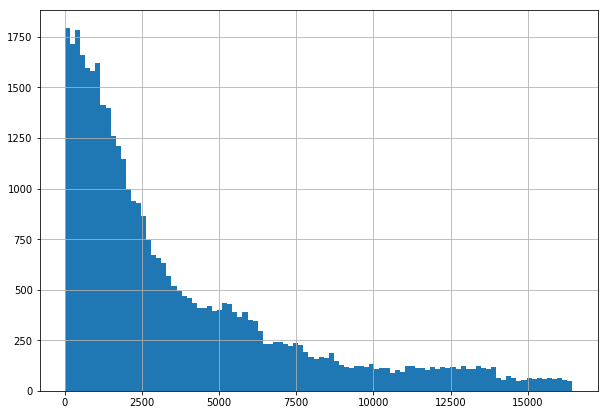

In [58]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

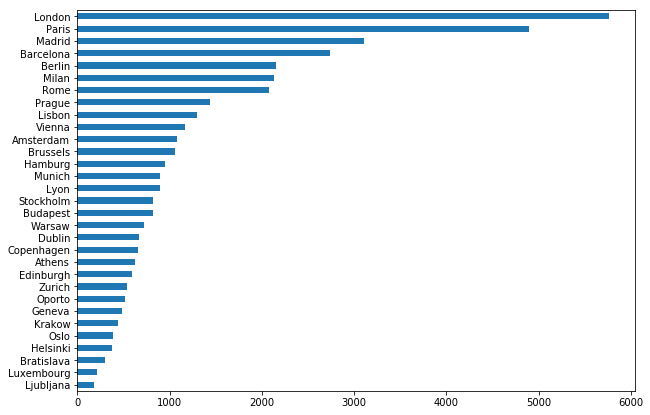

In [59]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

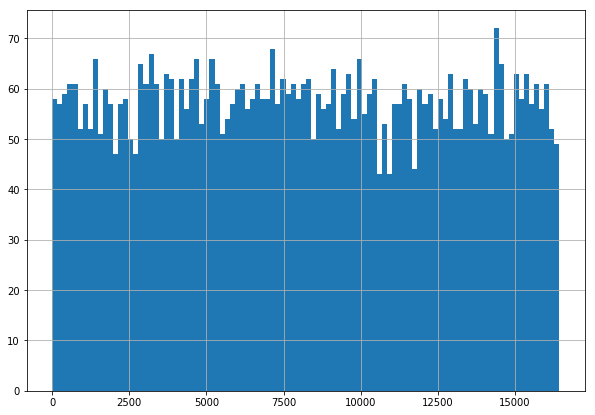

In [60]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

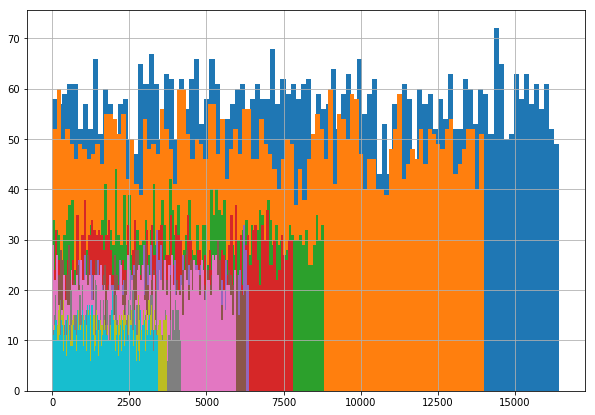

In [61]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

In [62]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

db=fix_columns(data)
db=ff_restaurant_id(db)
db.head()

fix_columns: старт функции
fix_columns: произведенна коррекция наименований столбцов.
ff_restaurant_id: старт функции
ff_restaurant_id: создадим новый признак сетевого ресторана (1-Да,0-Нет)
ff_restaurant_id: создадим новый признак число ресторанов в городе
ff_restaurant_id: конец функции


restaurant_id        city  \
0          id_0       Paris   
1          id_1    Helsinki   
2          id_2   Edinburgh   
3          id_3      London   
4          id_4  Bratislava   

                                       cuisine_style  ranking price_range  \
0                                     ['Bar', 'Pub']  12963.0    $$ - $$$   
1  ['European', 'Scandinavian', 'Gluten Free Opti...    106.0    $$ - $$$   
2                            ['Vegetarian Friendly']    810.0    $$ - $$$   
3  ['Italian', 'Mediterranean', 'European', 'Vege...   1669.0        $$$$   
4  ['Italian', 'Mediterranean', 'European', 'Seaf...     37.0        $$$$   

   number_of_reviews                                            reviews  \
0                4.0                                           [[], []]   
1               97.0  [['Very good reviews!', 'Fine dining in Hakani...   
2               28.0  [['Better than the Links', 'Ivy Black'], ['12/...   
3              202.0  [['Most exquisite', 'Delicious and authentic']...   
4              162.0  [['Always the best in bratislava', 'Very good ...   

                                              url_ta      id_ta  sample  \
0  /Restaurant_Review-g187147-d10746918-Reviews-L...  d10746918       0   
1  /Restaurant_Review-g189934-d6674944-Reviews-Ra...   d6674944       0   
2  /Restaurant_Review-g186525-d13129638-Reviews-B...  d13129638       0   
3  /Restaurant_Review-g186338-d680417-Reviews-Qui...    d680417       0   
4  /Restaurant_Review-g274924-d1112354-Reviews-Ma...   d1112354       0   

   rating  restaurant_chain  restaurant_amount_in_city  
0     0.0                 1                       6108  
1     0.0                 1                        475  
2     0.0                 1                        745  
3     0.0                 1                       7193  
4     0.0                 1                        380

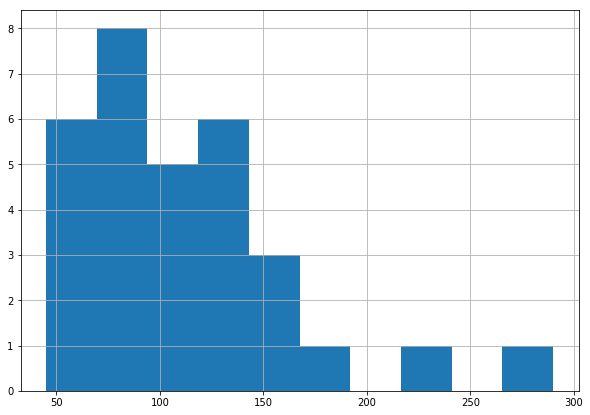

In [63]:
db.groupby('city')['number_of_reviews'].apply(lambda x: round(x.mean())).hist()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


видна зависимость между ranking и числом ресторанов.  
восмотрим на это поближе через корреляцию

ranking  restaurant_amount_in_city  \
ranking                    1.000000                   0.709012   
restaurant_amount_in_city  0.709012                   1.000000   
number_of_reviews         -0.223775                   0.024510   

                           number_of_reviews  
ranking                            -0.223775  
restaurant_amount_in_city           0.024510  
number_of_reviews                   1.000000

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


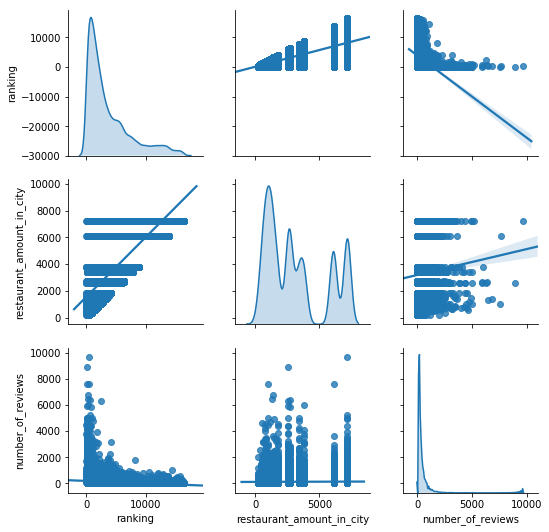

In [64]:
display(db[["ranking","restaurant_amount_in_city","number_of_reviews"]].corr())
sns.pairplot(db, vars = ["ranking","restaurant_amount_in_city","number_of_reviews"], kind = 'reg',diag_kind="kde")

чтоже подозрения подтвердились, попробуем компенсировать это

In [65]:
db['restaurant_amount_in_city_norm'] = db['restaurant_amount_in_city']/db['ranking']
db['ranking_norm_by_nrest'] = db['ranking']/db['restaurant_amount_in_city']

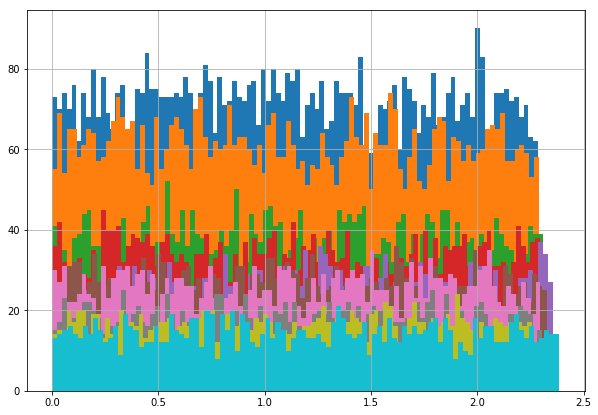

In [66]:
# посмотрим на топ 10 городов
for x in (db['city'].value_counts())[0:10].index:
    db['ranking_norm_by_nrest'][db['city'] == x].hist(bins=100)
plt.show()

так лучше

ranking_norm_by_nrest  \
ranking_norm_by_nrest                        1.000000   
restaurant_amount_in_city_norm              -0.108969   
number_of_reviews                           -0.401315   

                                restaurant_amount_in_city_norm  \
ranking_norm_by_nrest                                -0.108969   
restaurant_amount_in_city_norm                        1.000000   
number_of_reviews                                     0.120980   

                                number_of_reviews  
ranking_norm_by_nrest                   -0.401315  
restaurant_amount_in_city_norm           0.120980  
number_of_reviews                        1.000000

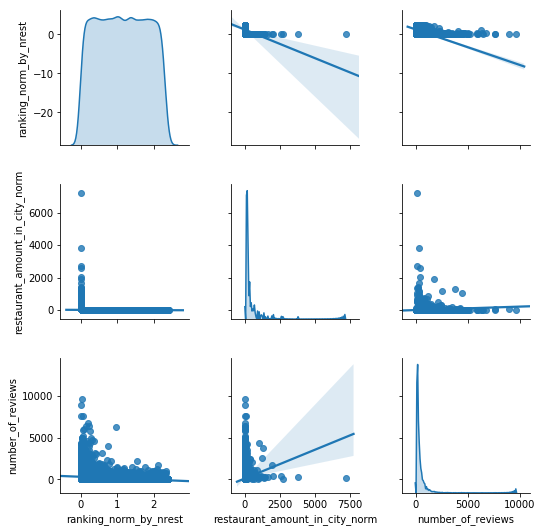

In [67]:
display(db[["ranking_norm_by_nrest","restaurant_amount_in_city_norm","number_of_reviews"]].corr())
sns.pairplot(db, vars = ["ranking_norm_by_nrest","restaurant_amount_in_city_norm","number_of_reviews"], kind = 'reg',diag_kind="kde")

In [68]:
list_cols=["ranking","restaurant_amount_in_city","number_of_reviews"]
for col in list_cols:
    if db[col].isna().sum()>0:
        print(col,',',db[col].isna().sum())
        
db["number_of_reviews"]=db["number_of_reviews"].fillna(db.groupby('city')['number_of_reviews'].transform('mean'))

number_of_reviews , 3200


In [69]:
#  попробуем использовать полиномиальные функции
#  https://chel-center.ru/python-yfc/2020/12/20/linejnaya-regressiya-v-python/
#  https://www.machinelearningmastery.ru/machine-learning-polynomial-regression-with-python-5328e4e8a386/
#  https://pythobyte.com/polynomial-regression-in-python-e35c2a06/
pf = PolynomialFeatures(2)
p_cols = pf.fit_transform(db[['restaurant_amount_in_city', 'ranking','number_of_reviews']])
col_names = ['col_1','col_2','col_3','col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9', 'col_10']
poly=pd.DataFrame(p_cols, columns=col_names)
poly.head(10)

col_1   col_2    col_3       col_4       col_5       col_6         col_7  \
0    1.0  6108.0  12963.0    4.000000  37307664.0  79178004.0  2.443200e+04   
1    1.0   475.0    106.0   97.000000    225625.0     50350.0  4.607500e+04   
2    1.0   745.0    810.0   28.000000    555025.0    603450.0  2.086000e+04   
3    1.0  7193.0   1669.0  202.000000  51739249.0  12005117.0  1.452986e+06   
4    1.0   380.0     37.0  162.000000    144400.0     14060.0  6.156000e+04   
5    1.0  6108.0   5093.0   24.000000  37307664.0  31108044.0  1.465920e+05   
6    1.0  1647.0   3704.0    2.000000   2712609.0   6100488.0  3.294000e+03   
7    1.0  1021.0   2330.0  158.680214   1042441.0   2378930.0  1.620125e+05   
8    1.0   475.0    771.0    2.000000    225625.0    366225.0  9.500000e+02   
9    1.0  1033.0    605.0   13.000000   1067089.0    624965.0  1.342900e+04   

         col_8          col_9        col_10  
0  168039369.0   51852.000000     16.000000  
1      11236.0   10282.000000   9409.000000  
2     656100.0   22680.000000    784.000000  
3    2785561.0  337138.000000  40804.000000  
4       1369.0    5994.000000  26244.000000  
5   25938649.0  122232.000000    576.000000  
6   13719616.0    7408.000000      4.000000  
7    5428900.0  369724.898396  25179.410285  
8     594441.0    1542.000000      4.000000  
9     366025.0    7865.000000    169.000000

### Посмотрим распределение целевой переменной

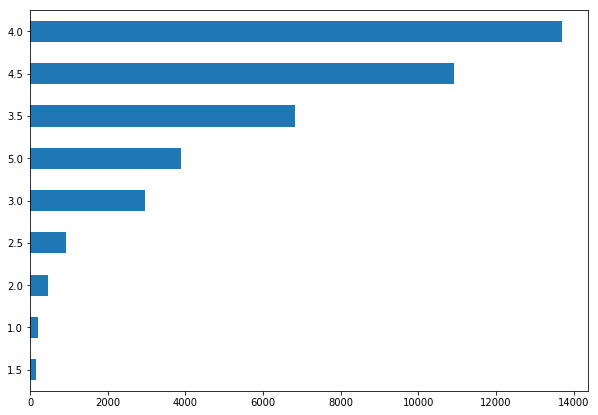

In [70]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

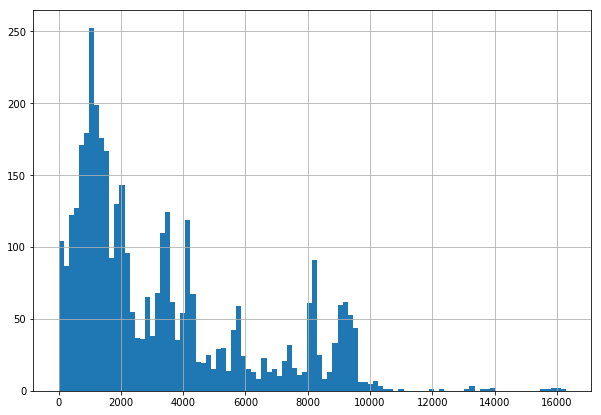

In [71]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

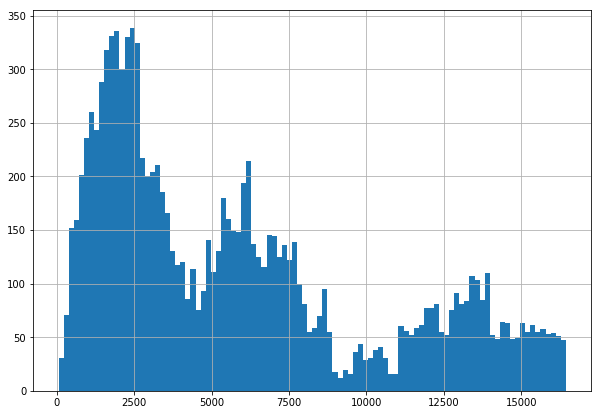

In [72]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

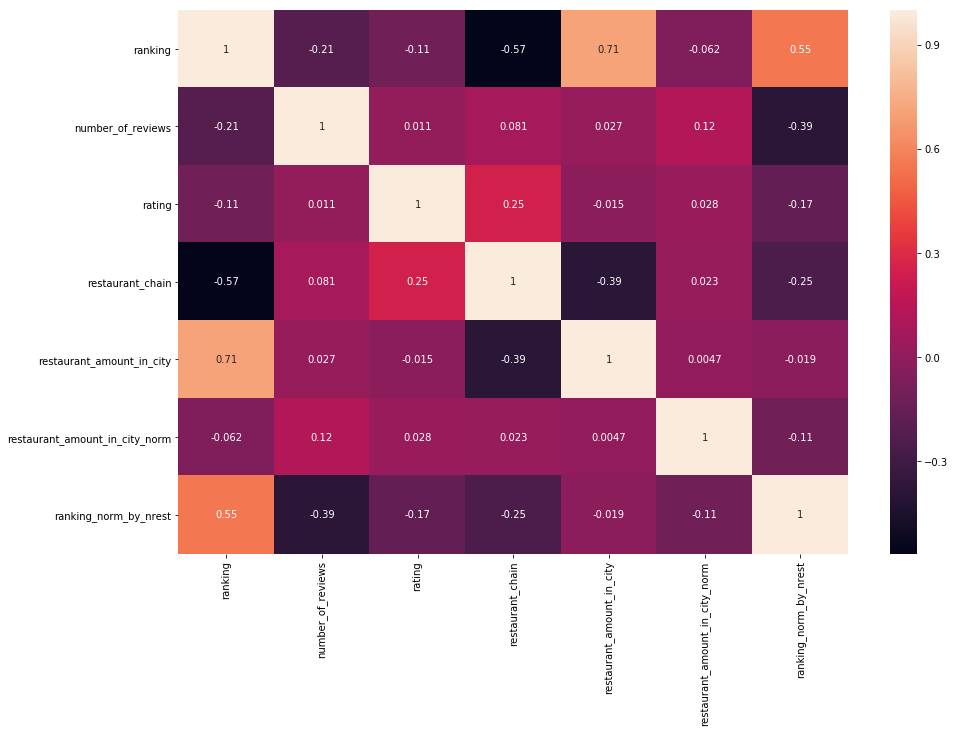

In [73]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(db.drop(['sample'], axis=1).corr(),annot = True)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [74]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [75]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    print('preproc_data:','старт функции')
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
#     df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)  # мне нужен столбец 'Restaurant_id'
    
    # исправим наименования столбцов
    df_output=fix_columns(df_output)
    #     
    # сохраню изначальные данные для последующей проверки моих замен по пропускам в данных
#     data_org=df_output.copy()  # я потом использую данные для формирования новых признаков
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
#     df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    # получим список с пропусками в данных
    col_wh_missing_data=list_missing_data(df_output)
    
    # сохраним какие именно строчки были с пропущенными данными 
    df_output=save_col_wh_nans(df_output,list_missing_data(df_output))
    
    # необходимо отдельно создать признак пропущенных данных для столбца 'reviews'
    print('preproc_data:','создаем признак reviews_isNAN')
    df_output['reviews_isNAN'] = df_output['reviews'].apply(lambda x: int(1) if x=="[[], []]" or pd.isna(x)==int(1) else int(0))

    # заполним пропуски в данных
    df_output=fill_first_cloumns(df_output)
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
#     df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    df_output=processing_cities(df_output) # get_dummies для столбца 'city'
    df_output=fix_columns(df_output) # переводим названия столбцов в нижний регистр
    
    # сделаем оба варианта Encoding по столбцу 'price_range' лишнее потом удалим
    df_output=processing_price_range_v1(df_output)
    df_output=processing_price_range_v2(df_output)
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    # начнем с признака 'cuisine_style'
    df_output=prep_cuisine_style(df_output)
    
    # исправим наименования столбцов после добывления новых столбцов
    df_output=fix_columns(df_output)
    
    # создаем новые признаки из поля 'cuisine_style'   
#     df_output=ff_cuisines(df_output)  # объеденил с prep_cuisine_style
    
    # создаем новые признаки из поля 'restaurant_id'  
    df_output=ff_restaurant_id(df_output)
    
    # создаем новые признаки из поля 'reviews' 
    df_output=ff_reviews(df_output)
#     display(df_output.head())
    
    # добавляем статданные (расчитаем и + загрузим новые)
    df_output=ff_add_city_info(df_output)
    
    # сделаем новые признаки - страны   
    print('preproc_data:','делаем get_dummies для стран')
    df_output = pd.get_dummies(df_output, columns = ['Country'])
    
    # исправим наименования столбцов
    df_output=fix_columns(df_output)
    
    
    # создаем новые признаки
    print('preproc_data:','создаем признак ranking_norm')
    df_output=calc_ranking_norm(df_output)
    
    print('preproc_data:','создаем признак number_of_reviews_norm2')
    df_output=calc_number_of_reviews_norm2(df_output)
    
    print('preproc_data:','создаем признак reviews_days_ago_norm')
    df_output=calc_reviews_days_ago_norm(df_output)
    
    print('preproc_data:','создаем признак cuisine_style_amount_norm')
    df_output=calc_cuisine_style_amount_norm(df_output)
    
    print('preproc_data:','создаем признак cuisine_style_amount_norm2')
    df_output=calc_cuisine_style_amount_norm2(df_output)
        
    print('preproc_data:','создаем признаки data_in2')
    df_output=calc_data_in2(df_output)
    
    df_output['number_of_reviews_norm'].fillna(round(df_output['number_of_reviews_norm'].mean()), inplace=True)
    
    # функцию уже не писал - сюда копирую код   
    print('preproc_data:','создаем новые нормированные признаки число ресторанов в городе и ранкинг')
    df_output['restaurant_amount_in_city_norm'] = df_output['restaurant_amount_in_city']/df_output['ranking']
    df_output['ranking_norm_by_nrest'] = df_output['ranking']/df_output['restaurant_amount_in_city']
    
   
    # не хватает памяти для финальной обработки
#     df_output = pd.get_dummies(df_output, columns = ['restaurant_id'])
    
    #  попробуем использовать полиномиальные функции
    print('preproc_data:','попробуем использовать полиномиальные функции')
    pf = PolynomialFeatures(2)
    p_cols = pf.fit_transform(df_output[['restaurant_amount_in_city', 'ranking','number_of_reviews']])
    col_names = ['col_1','col_2','col_3','col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9', 'col_10']
    poly=pd.DataFrame(p_cols, columns=col_names)
    
    # переберу по очереди столбцы и останавлюсь на одном    
    df_output= pd.concat([df_output, poly['col_9']], axis=1)
    df_output= pd.concat([df_output, poly['col_7']], axis=1)
    
    print('preproc_data:','удалим старые признаки')
    df_output.drop(['ranking','number_of_reviews','number_of_reviews'
#                     ,'ranking_norm','number_of_reviews_norm2',
#                      'ranking_in2','number_of_reviews_in2','restaurant_amount_in_city','cuisine_style_amount_norm',
#                      'review_analyse'
                   ], axis = 1, inplace=True)
#     'ranking_norm','number_of_reviews_norm2','ranking_in2','number_of_reviews_in2'
# restaurant_amount_in_city, cuisine_style_amount_norm
# review_analyse
    

    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
#     object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    print('preproc_data:','удаляем текстовые и временные признаки из рабочего набора данных')
    object_columns  = list(df_output.select_dtypes(include=['object', 'datetime64[ns]', 'timedelta64[ns]']).columns)
    df_output.drop(object_columns, axis = 1, inplace=True)
    
 
    # и проведем финальную нормализацию данных
    print('preproc_data:','нормализуем рабочий массив')
    df_output=fin_norm_dataset(df_output)
    
    print('preproc_data:','конец функции')
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [76]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

preproc_data: старт функции
fix_columns: старт функции
fix_columns: произведенна коррекция наименований столбцов.
list_missing_data: старт функции
list_missing_data: проходим циклом по всем столбцам и если есть пропуск - добавляем в список
list_missing_data: конец функции
list_missing_data: старт функции
list_missing_data: проходим циклом по всем столбцам и если есть пропуск - добавляем в список
list_missing_data: конец функции
save_col_wh_nans: старт функции
save_col_wh_nans: проходимся циклом по списку, создаем новый признак по названию столбца +_isNAN и ставим 1 - если есть пропуск, 0 - нету.
save_col_wh_nans: конец функции
preproc_data: создаем признак reviews_isNAN
fill_first_cloumns: старт функции
fill_first_cloumns: нормализуем признак "number_of_reviews"
fill_first_cloumns: заполняем пропуски признака "cuisine_style" значением "Other"
fill_first_cloumns: заполняем пропуски признака "price_range" значением "Other"
fill_first_cloumns: заполняем пропуски признака "number_of_review

sample  rating  cuisine_style_isnan  price_range_isnan  \
36252     1.0     4.0                  0.0                0.0   
31732     1.0     3.5                  0.0                0.0   
6115      0.0     0.0                  1.0                1.0   
1527      1.0     3.5                  0.0                0.0   
11001     1.0     2.5                  1.0                1.0   
16629     0.0     0.0                  0.0                0.0   
23313     1.0     4.5                  1.0                1.0   
17204     1.0     4.5                  1.0                1.0   
34940     1.0     4.0                  0.0                0.0   
14282     1.0     5.0                  1.0                1.0   

       number_of_reviews_isnan  reviews_isnan  number_of_reviews_norm  \
36252                      0.0            0.0                0.553765   
31732                      0.0            0.0                0.453224   
6115                       1.0            1.0                0.371294   
1527                       0.0            1.0                0.000000   
11001                      0.0            0.0                0.000000   
16629                      0.0            0.0                0.495663   
23313                      0.0            1.0                0.239945   
17204                      0.0            1.0                0.092823   
34940                      0.0            0.0                0.397786   
14282                      0.0            0.0                0.054298   

       city_amsterdam  city_athens  city_barcelona  city_berlin  \
36252             0.0          0.0             0.0          0.0   
31732             0.0          0.0             1.0          0.0   
6115              0.0          0.0             0.0          0.0   
1527              0.0          0.0             0.0          0.0   
11001             0.0          0.0             0.0          0.0   
16629             0.0          0.0             0.0          0.0   
23313             0.0          0.0             0.0          0.0   
17204             0.0          0.0             0.0          0.0   
34940             0.0          0.0             0.0          0.0   
14282             0.0          0.0             0.0          0.0   

       city_bratislava  city_brussels  city_budapest  city_copenhagen  \
36252              0.0            0.0            0.0              0.0   
31732              0.0            0.0            0.0              0.0   
6115               0.0            0.0            0.0              0.0   
1527               0.0            0.0            0.0              0.0   
11001              0.0            0.0            0.0              0.0   
16629              0.0            0.0            1.0              0.0   
23313              0.0            0.0            0.0              0.0   
17204              0.0            0.0            1.0              0.0   
34940              0.0            1.0            0.0              0.0   
14282              0.0            0.0            0.0              0.0   

       city_dublin  city_edinburgh  city_geneva  city_hamburg  city_helsinki  \
36252          0.0             0.0          0.0           0.0            0.0   
31732          0.0             0.0          0.0           0.0            0.0   
6115           0.0             0.0          0.0           0.0            1.0   
1527           0.0             0.0          0.0           0.0            0.0   
11001          0.0             0.0          0.0           0.0            0.0   
16629          0.0             0.0          0.0           0.0            0.0   
23313          0.0             0.0          0.0           0.0            0.0   
17204          0.0             0.0          0.0           0.0            0.0   
34940          0.0             0.0          0.0           0.0            0.0   
14282          0.0             0.0          0.0           0.0            0.0   

       city_krakow  city_lisbon  city_ljubljana  city_london  ci

In [77]:
list_missing_data(df_preproc)

list_missing_data: старт функции
list_missing_data: проходим циклом по всем столбцам и если есть пропуск - добавляем в список
list_missing_data: конец функции


[]

In [78]:
for col in df_preproc.columns:
    if df_preproc[col].isna().sum()>0:
        print(col,',',df_preproc[col].isna().sum())

In [79]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_preproc.sample(25).T

32166     20092     35676     30478  \
sample                          1.000000  1.000000  0.000000  0.000000   
rating                          4.500000  3.500000  0.000000  0.000000   
cuisine_style_isnan             1.000000  0.000000  0.000000  1.000000   
price_range_isnan               1.000000  1.000000  0.000000  1.000000   
number_of_reviews_isnan         0.000000  0.000000  0.000000  0.000000   
reviews_isnan                   1.000000  1.000000  0.000000  1.000000   
number_of_reviews_norm          0.185647  0.562072  0.448606  0.000000   
city_amsterdam                  0.000000  0.000000  0.000000  0.000000   
city_athens                     0.000000  0.000000  0.000000  0.000000   
city_barcelona                  1.000000  0.000000  0.000000  1.000000   
city_berlin                     0.000000  0.000000  0.000000  0.000000   
city_bratislava                 0.000000  0.000000  0.000000  0.000000   
city_brussels                   0.000000  0.000000  0.000000  0.000000   
city_budapest                   0.000000  0.000000  0.000000  0.000000   
city_copenhagen                 0.000000  0.000000  0.000000  0.000000   
city_dublin                     0.000000  0.000000  0.000000  0.000000   
city_edinburgh                  0.000000  0.000000  0.000000  0.000000   
city_geneva                     0.000000  0.000000  0.000000  0.000000   
city_hamburg                    0.000000  0.000000  0.000000  0.000000   
city_helsinki                   0.000000  0.000000  0.000000  0.000000   
city_krakow                     0.000000  0.000000  0.000000  0.000000   
city_lisbon                     0.000000  0.000000  0.000000  0.000000   
city_ljubljana                  0.000000  0.000000  0.000000  0.000000   
city_london                     0.000000  0.000000  0.000000  0.000000   
city_luxembourg                 0.000000  0.000000  0.000000  0.000000   
city_lyon                       0.000000  0.000000  0.000000  0.000000   
city_madrid                     0.000000  0.000000  1.000000  0.000000   
city_milan                      0.000000  0.000000  0.000000  0.000000   
city_munich                     0.000000  0.000000  0.000000  0.000000   
city_oporto                     0.000000  0.000000  0.000000  0.000000   
city_oslo                       0.000000  0.000000  0.000000  0.000000   
city_paris                      0.000000  0.000000  0.000000  0.000000   
city_prague                     0.000000  0.000000  0.000000  0.000000   
city_rome                       0.000000  1.000000  0.000000  0.000000   
city_stockholm                  0.000000  0.000000  0.000000  0.000000   
city_vienna                     0.000000  0.000000  0.000000  0.000000   
city_warsaw                     0.000000  0.000000  0.000000  0.000000   
city_zurich                     0.000000  0.000000  0.000000  0.000000   
price_range_in_num              0.500000  0.500000  0.500000  0.500000   
price_range_1                   0.000000  0.000000  0.000000  0.000000   
price_range_2                   1.000000  1.000000  1.000000  1.000000   
price_range_3                   0.000000  0.000000  0.000000  0.000000   
cuisine_style_amount            0.000000  0.000000  0.050000  0.000000   
afghani                         0.000000  0.000000  0.000000  0.000000   
african                         0.000000  0.000000  0.000000  0.000000   
albanian                        0.000000  0.000000  0.000000  0.000000   
american                        0.000000  0.000000  0.000000  0.000000   
arabic                          0.000000  0.000000  0.000000  0.000000   
argentinean                     0.000000  0.000000  0.000000  0.000000   
armenian                        0.000000  0.000000  0.000000  0.000000   
asian                           0.000000  0.000000  0.000000  0.000000   
australian                      0.000000  0.000000  0.000000  0.000000   
austrian                        0.000000  0.000000  0.000000  0.000000   
azerbaijani                     0.00000

### посмотрим на таблицу корреляций (график плохочитаем при таком числе признаков)

In [80]:
# уберем "лишние" столбцы из набора данныех для проведения корреляционного анализа

list_of_countries = []
list_of_cities=[]
list_of_cuisines=[]

prefix_city = "city_"
prefix_country = "country_"
prefix_cuisines = "cuisine_"

for col in df_preproc.columns:
    if col.startswith(prefix_city):
        list_of_cities.append(col)
    elif col.startswith(prefix_country):
        list_of_countries.append(col)
    elif col.startswith(prefix_cuisines):
        list_of_cuisines.append(col)
    else:
        # оставляем
        pass

list_of_columns_to_drop = list(set(list_of_cuisines + list_of_cities + list_of_countries))

In [81]:
list_additional_to_drop=["sample"]#,"price_range_in_num","reviews_days_ago","min_number_of_reviews","reviews_days_ago_in_city","max_cuisine_style_amount_citymean",
                         #"min_cuisine_style_amount_citymean","reviews_days_ago_isNAN","max_ranking","min_ranking"]

# уберем лишние столбцы, при этом оставим строчки только из набора для предсказания рейтинга
corr_data = df_preproc[df_preproc["sample"] == 1].drop(list_of_columns_to_drop, 1).drop(list_additional_to_drop, 1).corr()
display(corr_data)

rating  price_range_isnan  \
rating                          1.000000          -0.064567   
price_range_isnan              -0.064567           1.000000   
number_of_reviews_isnan         0.008386           0.266923   
reviews_isnan                  -0.024727           0.414213   
number_of_reviews_norm         -0.004985          -0.583606   
price_range_in_num             -0.028588           0.209937   
price_range_1                   0.064128          -0.314664   
price_range_2                  -0.087754           0.356095   
price_range_3                   0.060862          -0.140052   
afghani                         0.004233          -0.010387   
african                         0.019068          -0.028374   
albanian                        0.008082           0.000827   
american                       -0.026712          -0.099398   
arabic                          0.006661          -0.014282   
argentinean                     0.013076          -0.040212   
armenian                        0.007193          -0.005222   
asian                          -0.004329          -0.162073   
australian                      0.003310          -0.013578   
austrian                        0.008346          -0.045971   
azerbaijani                     0.002718          -0.005156   
balti                           0.002119          -0.032098   
bangladeshi                     0.000884          -0.024580   
bar                            -0.018162          -0.187048   
barbecue                        0.003314          -0.067642   
belgian                        -0.017870          -0.044721   
brazilian                       0.006904          -0.029019   
brew_pub                        0.018037          -0.035185   
british                         0.008431          -0.124720   
burmese                         0.007533          -0.003646   
cafe                            0.026566          -0.108880   
cajun_creole                    0.007762          -0.011612   
cambodian                       0.006089          -0.009262   
canadian                        0.001789          -0.008153   
caribbean                       0.010210          -0.015576   
caucasian                       0.003845          -0.007292   
central_american                0.000929          -0.042435   
central_asian                   0.006660          -0.012632   
central_european                0.022074          -0.131640   
chilean                         0.005437          -0.006600   
chinese                        -0.056867          -0.047392   
colombian                       0.001070          -0.006913   
contemporary                    0.034783          -0.068677   
croatian                        0.010351          -0.012886   
cuban                           0.009611          -0.010919   
czech                          -0.002582          -0.026269   
danish                          0.012246          -0.033583   
delicatessen                    0.045649          -0.042158   
diner                           0.002428          -0.029098   
dutch                           0.021477          -0.048607   
eastern_european                0.012828          -0.073642   
ecuadorean                     -0.012987          -0.002041   
egyptian                        0.005252          -0.009262   
ethiopian                       0.013041          -0.020399   
european                        0.047848          -0.335548   
fast_food                      -0.010855          -0.097455   
filipino                        0.008819          -0.009600   
french                          0.013076          -0.135384   
fujian                          0.005363          -0.005156   
fusion                          0.036864          -0.066639   
gastropub                       0.020380          -0.063047   
georgian                        0.002029          -0.015036   
german                          0.012492          -0.067018   
gluten_free_options             0.099455          -0.245657   
gr

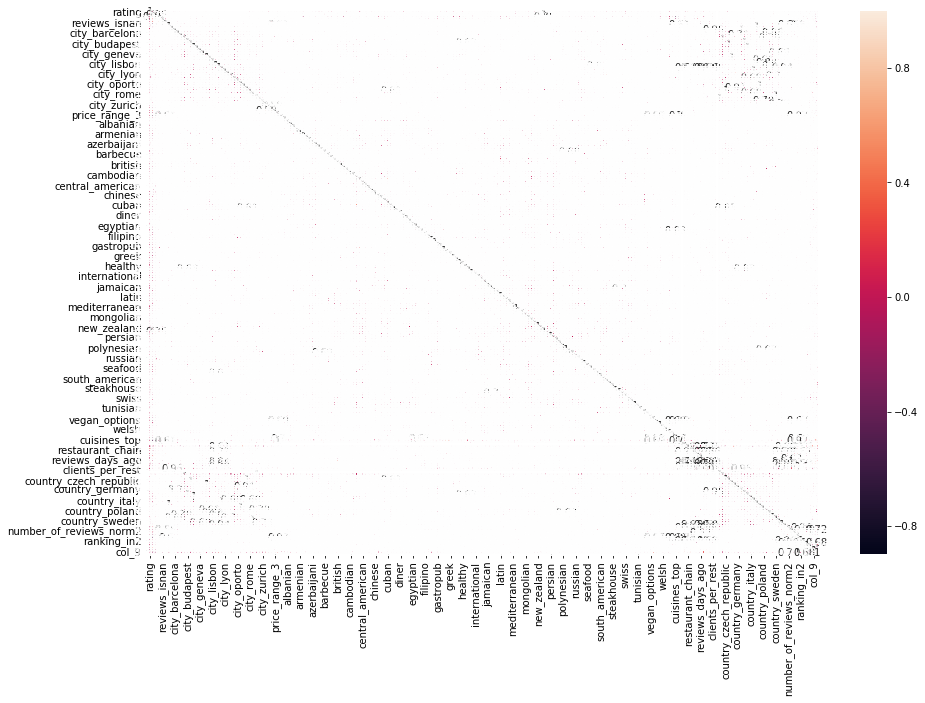

In [82]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df_preproc.drop(['sample'], axis=1).corr(),annot = True)

In [83]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [84]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [85]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 214), (40000, 214), (40000, 213), (32000, 213), (8000, 213))

# Model 
Сам ML

In [86]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [87]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [88]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [89]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2145559208790372


In [90]:
#1: MAE: 0.21514437499999997                                            (первый запуск через df_preproc)
#2: MAE: 0.21522187499999998                                            (отключил нормализацию)
#3: MAE: 0.19866625                                                     (включил нормализацию и + ввел новый признак 'ranking_absolute') 
# прошел какой то сбой(((( и практически всё заново...

#1: MAE: 0.2021375
#2: MAE: 0.20177812499999997                                            (добавил новый признак 'ranking_absolute_in2')
#3: MAE: 0.20179750000000002                                            (без нормализации и удаления столбца 'myind_x') 
#4: MAE: 0.20149812499999997                                            (добавлены два столбца 'number_of_reviews_norm' и 'number_of_reviews_norm2')
#5: MAE: 0.201411875                                                    (добавлены куча столбцов) 
#6: MAE: 0.20139687499999998                                            (удалил 'max_cuisine_style_amount_citymean','min_cuisine_style_amount_citymean')

#7: MAE: 0.20595875                                                     (добавил новый признаки по странам, численность городо и число туристов) 
#8: MAE: 0.205693125                                                    (удалил 'cuisine_style_amount_norm')  
#9: MAE: 0.20063499999999998                                            (удалил столбцы из шага #7 и 'reviews_days_ago_norm','max_cuisine_style_amount_citymean','min_cuisine_style_amount_citymean','cuisine_style_amount_norm')  
#10: MAE: 0.2058825                                                     (добавил столбцы 'population','tourists','clients_in_city','clients_per_rest', но без стран)
#    пока получается, что добытая дополнительная информация ухудшает показатель, а не улучшает его, как я ожидал.
#11: MAE: 0.20594687499999997                                           (удалил столбцы 'population','tourists','clients_in_city')
#12: MAE: 0.2021375      
#13: MAE: 0.20166937499999998                                           (удалил столбцы ['myind_x','reviews_days_ago','max_ranking','min_ranking'])
#14: MAE: 0.20125562500000002                   !!!!                    (добавлены куча столбцов)                    

# MAE: 0.2014125 поменял % для rare_cuisines на 10%

# сделал submission --- score = 0.68375... как так...

# переписал всю работу, исключил merge (за исключение дополнительной информации)

# MAE: 0.2129173346538579    --- переписал функции по обработке review и cuisines_style
# работаем дальше.
# MAE: 0.2166357347059888
# MAE: 0.227597630758488           переписал все - убрал все merge
# MAE: 0.22634417518547634        нормализовал данные
# MAE: 0.2220159643444165         вернул city dummies

# MAE: 0.22190406783472152       вернул dummies для кухонь

# MAE: 0.21500608958472317      col_2
#1 MAE: 0.21504737469594762      удаляю лишние столбцы
#2 MAE: 0.21597433413348177

# пробуем другие полиномиальные функции (вернул на #1)
#3  MAE: 0.21504475352867933     col_3
#4  MAE: 0.21507046355600154     col_4
#5  MAE: 0.21504862469594757     col_5
#6  MAE: 0.21498788934658314     col_6
#7  MAE: 0.21474613664338651     col_7
#8  MAE: 0.2150633833277441      col_8
#9  MAE: 0.21468601257753886     col_9    лучший вариант - оставляю его
#10 MAE: 0.21508546355600158     col_10
#11 MAE: 0.21652208009469512     удалил признаки 'ranking_norm','number_of_reviews_norm2','ranking_in2','number_of_reviews_in2' restaurant_amount_in_city, cuisine_style_amount_norm
#12 MAE: 0.21730553439484548     удалил ещё review_analyse
#13 MAE: 0.21471711266973323     никакие признаки не удалял и col_9 
#14 MAE: 0.21465175390574628     удалены признаки 'ranking','number_of_reviews','number_of_reviews' и оставлены два столбца col_9 и col_7 (большой погоды это не дало)


#15 MAE: 0.21566436471047223     убрал полиномиальные функции и вернул дополнительную информацию
#16 MAE: 0.21611155058027334     отключил get_dummies по странам 
#17 MAE: 0.2150821768755337      вернул полиномиальные функции и отключил get_dummies по странам 
#18 MAE: 0.2145559208790372      вернул get_dummies по странам 

#останавливаюсь на этом







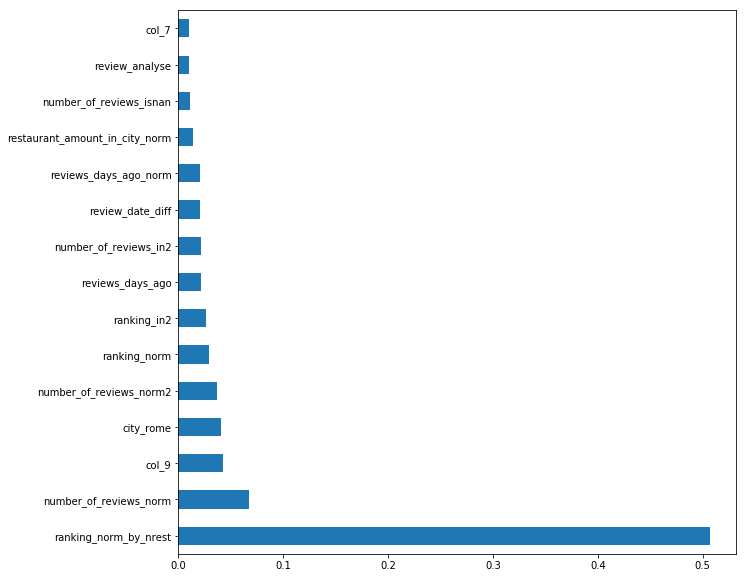

In [91]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [92]:
test_data.sample(10)

rating  cuisine_style_isnan  price_range_isnan  \
7739      0.0                  0.0                0.0   
40715     0.0                  1.0                1.0   
47435     0.0                  0.0                1.0   
17644     0.0                  1.0                1.0   
35152     0.0                  1.0                1.0   
39606     0.0                  0.0                0.0   
7534      0.0                  0.0                0.0   
30714     0.0                  0.0                1.0   
8213      0.0                  0.0                0.0   
8626      0.0                  0.0                0.0   

       number_of_reviews_isnan  reviews_isnan  number_of_reviews_norm  \
7739                       0.0            0.0                0.431059   
40715                      0.0            0.0                0.054298   
47435                      0.0            0.0                0.228293   
17644                      0.0            0.0                0.286589   
35152                      0.0            0.0                0.353412   
39606                      0.0            0.0                0.643335   
7534                       0.0            0.0                0.649764   
30714                      0.0            0.0                0.286589   
8213                       0.0            0.0                0.534189   
8626                       0.0            0.0                0.397786   

       city_amsterdam  city_athens  city_barcelona  city_berlin  \
7739              0.0          0.0             0.0          0.0   
40715             0.0          0.0             0.0          1.0   
47435             0.0          0.0             0.0          0.0   
17644             0.0          0.0             0.0          0.0   
35152             0.0          0.0             0.0          0.0   
39606             1.0          0.0             0.0          0.0   
7534              0.0          0.0             0.0          0.0   
30714             0.0          0.0             1.0          0.0   
8213              0.0          0.0             0.0          0.0   
8626              0.0          0.0             0.0          0.0   

       city_bratislava  city_brussels  city_budapest  city_copenhagen  \
7739               0.0            0.0            0.0              0.0   
40715              0.0            0.0            0.0              0.0   
47435              0.0            0.0            0.0              1.0   
17644              0.0            0.0            0.0              0.0   
35152              0.0            0.0            0.0              0.0   
39606              0.0            0.0            0.0              0.0   
7534               0.0            0.0            0.0              0.0   
30714              0.0            0.0            0.0              0.0   
8213               0.0            0.0            0.0              0.0   
8626               0.0            0.0            0.0              0.0   

       city_dublin  city_edinburgh  city_geneva  city_hamburg  city_helsinki  \
7739           0.0             0.0          0.0           0.0            0.0   
40715          0.0             0.0          0.0           0.0            0.0   
47435          0.0             0.0          0.0           0.0            0.0   
17644          0.0             0.0          0.0           0.0            0.0   
35152          0.0             0.0          0.0           0.0            0.0   
39606          0.0             0.0          0.0           0.0            0.0   
7534           0.0             0.0          0.0           0.0            0.0   
30714          0.0             0.0          0.0           0.0            0.0   
8213           0.0             0.0          0.0           0.0            0.0   
8626           0.0             0.0          0.0           0.0            0.0   

       city_krakow  city_lisbon  city_ljubljana  city_london  city_luxembourg  \
7739           0.0          0.0             0.0          1.0           

In [93]:
test_data = test_data.drop(['rating'], axis=1)

In [94]:
sample_submission

Restaurant_id  Rating
0             id_0     2.0
1             id_1     2.5
2             id_2     4.0
3             id_3     1.0
4             id_4     4.0
5             id_5     4.5
6             id_6     4.5
7             id_7     2.0
8             id_8     2.0
9             id_9     3.5
10           id_10     5.0
11           id_11     3.5
12           id_12     2.5
13           id_13     1.0
14           id_14     5.0
15           id_15     4.5
16           id_16     1.5
17           id_17     2.0
18           id_18     4.5
19           id_19     3.5
20           id_20     2.0
21           id_21     2.0
22           id_22     1.0
23           id_23     2.5
24           id_24     2.5
25           id_25     4.0
26           id_26     4.0
27           id_27     1.5
28           id_28     2.0
29           id_29     4.0
30           id_30     2.5
31           id_31     5.0
32           id_32     2.5
33           id_33     1.5
34           id_34     3.0
35           id_35     3.5
36           id_36     1.5
37           id_37     1.0
38           id_38     4.0
39           id_39     2.0
40           id_40     3.0
41           id_41     3.0
42           id_42     4.5
43           id_43     3.0
44           id_44     5.0
45           id_45     4.5
46           id_46     2.0
47           id_47     2.0
48           id_48     4.5
49           id_49     1.5
50           id_50     5.0
51           id_51     1.0
52           id_52     5.0
53           id_53     1.0
54           id_54     3.0
55           id_55     1.0
56           id_56     3.0
57           id_57     1.5
58           id_58     4.0
59           id_59     2.5
60           id_60     2.0
61           id_61     4.5
62           id_62     5.0
63           id_63     2.0
64           id_64     3.0
65           id_65     1.5
66           id_66     5.0
67           id_67     1.5
68           id_68     1.5
69           id_69     4.5
70           id_70     4.5
71           id_71     1.0
72           id_72     3.0
73           id_73     2.0
74           id_74     3.5
75           id_75     4.5
76           id_76     4.0
77           id_77     2.5
78           id_78     2.0
79           id_79     5.0
80           id_80     5.0
81           id_81     3.0
82           id_82     2.0
83           id_83     4.5
84           id_84     4.0
85           id_85     1.0
86           id_86     4.0
87           id_87     5.0
88           id_88     5.0
89           id_89     4.0
90           id_90     3.5
91           id_91     4.0
92           id_92     4.5
93           id_93     5.0
94           id_94     5.0
95           id_95     5.0
96           id_96     1.5
97           id_97     1.5
98           id_98     4.5
99           id_99     5.0
100         id_100     4.0
101         id_101     4.0
102         id_102     3.0
103         id_103     2.5
104         id_104     1.5
105         id_105     2.5
106         id_106     1.0
107         id_107     2.5
108         id_108     4.5
109         id_109     4.0
110         id_110     2.5
111         id_111     4.5
112         id_112     1.5
113         id_113     2.0
114         id_114     4.5
115         id_115     2.5
116         id_116     1.5
117         id_117     3.0
118         id_118     1.0
119         id_119     4.0
120         id_120     3.5
121         id_121     1.5
122         id_122     4.5
123         id_123     2.5
124         id_124     3.0
125         id_125     3.5
126         id_126     2.5
127         id_127     2.5
128         id_128     4.5
129         id_129     1.0
130         id_130     4.0
131         id_131     1.5
132         id_132     5.0
133         id_133     3.0
134         id_134     4.0
135         id_135     1.5
136         id_136     5.0
137         id_137     4.0
138         id_138     4.0
139         id_139     1.5
140         id_140     3.0
141         id_141     2.5
142         id_142     4.5
143         id_143     1.0
144         id_144     3.5
145         id_145     3.0
146         id_146     4.5
147      

In [95]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [96]:
predict_submission

array([3.15529762, 4.36      , 3.08      , ..., 4.03      , 4.27      ,
       4.385     ])

In [97]:
# sample_submission['Rating'] = predict_submission
sample_submission['Rating'] = [np.round(x*2)/2 for x in predict_submission]
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

Restaurant_id  Rating
0          id_0     3.0
1          id_1     4.5
2          id_2     3.0
3          id_3     5.0
4          id_4     4.5
5          id_5     3.5
6          id_6     4.0
7          id_7     3.0
8          id_8     3.0
9          id_9     4.0

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
